# Linear regression for house prices

This notebooks corresponds to the experiments of Section 6.2 of the paper

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch.distributions import Gamma, MultivariateNormal
from torch.distributions.kl import kl_divergence

import numpyro
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer import SVI, Trace_ELBO

import jax.numpy as jnp
from jax.random import PRNGKey

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tqdm

from src.weights_optimizer import WeightsOptimizer
from src.horseshoe_lin_reg import HorseshoeLinearRegression
from src.utils import remove_zeros, to_tensor, nig_kl_div, to_np
from src.bayes_lin_reg import NIGLinearRegression

from src.boston_visualization_functions import plot_samples_kde_single_param, plot_samples_kde, plot_intervals_NIG

/home/mcarreau/miniconda3/envs/BayesAML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare the data

In [2]:
boston = fetch_openml(name="boston", version=1, as_frame=False)
X = boston.data.astype(np.float32)
y = boston.target.astype(np.float32)
n_features = X.shape[1]
feature_names = boston.feature_names

In [3]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

idx_to_scale = np.ones(len(boston.feature_names), dtype=bool)
idx_to_scale[boston.feature_names.index("CHAS")] = False

scaler = StandardScaler()
X_train[:, idx_to_scale] = scaler.fit_transform(X_train_raw[:, idx_to_scale])
X_train = np.concatenate((np.ones((X_train.shape[0], 1), dtype=np.float32), X_train), axis=1)

X_test[:, idx_to_scale] = scaler.fit_transform(X_test_raw[:, idx_to_scale])
X_test = np.concatenate((np.ones((X_test.shape[0], 1), dtype=np.float32), X_test), axis=1)

In [4]:
data_NIG = {"X": torch.tensor(X_train), "y":torch.tensor(y_train)}
data_HS = {"X": torch.tensor(X_train[:, 1:]), "y":torch.tensor(y_train)}

n_points = X_train.shape[0]

# Evaluate the models on the test set

### NIG prior

In [5]:
# Prior
mu0 = torch.zeros(n_features + 1, dtype=torch.float32)  # Prior mean vector for beta, including intercept
v0 = torch.eye(n_features + 1, dtype=torch.float32) * 100  # Prior covariance matrix for beta, including intercept
a0 = 2.0  # Shape parameter for the inverse gamma prior 
b0 = 2.0 # Rate parameter for the inverse gamma prior

# Adversarial
model_NIG = NIGLinearRegression(mu0, v0, a0, b0)

# Compute R2 score for NIG model
MAP_orig_NIG = to_np(model_NIG.posterior_parameters(data_NIG)[0])
y_test_pred = X_test @ MAP_orig_NIG
print("R2 for NIG:", r2_score(y_test, y_test_pred))

R2 for NIG: 0.6283810138702393


### Horseshoe Prior

In [6]:
model_HS = HorseshoeLinearRegression()

samples_HS = model_HS.sample_posterior(5000, data_HS, warmup_steps=500)
y_pred_Mean_HS = X_test[:, 1:] @ to_np(samples_HS["beta"].mean(0)) + float(samples_HS["intercept"].mean(0))
print("R2 for Horseshoe:", r2_score(y_test, y_pred_Mean_HS))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


R2 for Horseshoe: 0.6250708699226379


### Plot credible intervals for Horseshoe prior

In [7]:
CLR_ORIGINAL = "Green"
CLR_TARGET = "Red"
CLR_TAINTED = "Blue"

colors = [CLR_ORIGINAL, CLR_TARGET, CLR_TAINTED]

/tmp/ipykernel_1483427/106227084.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


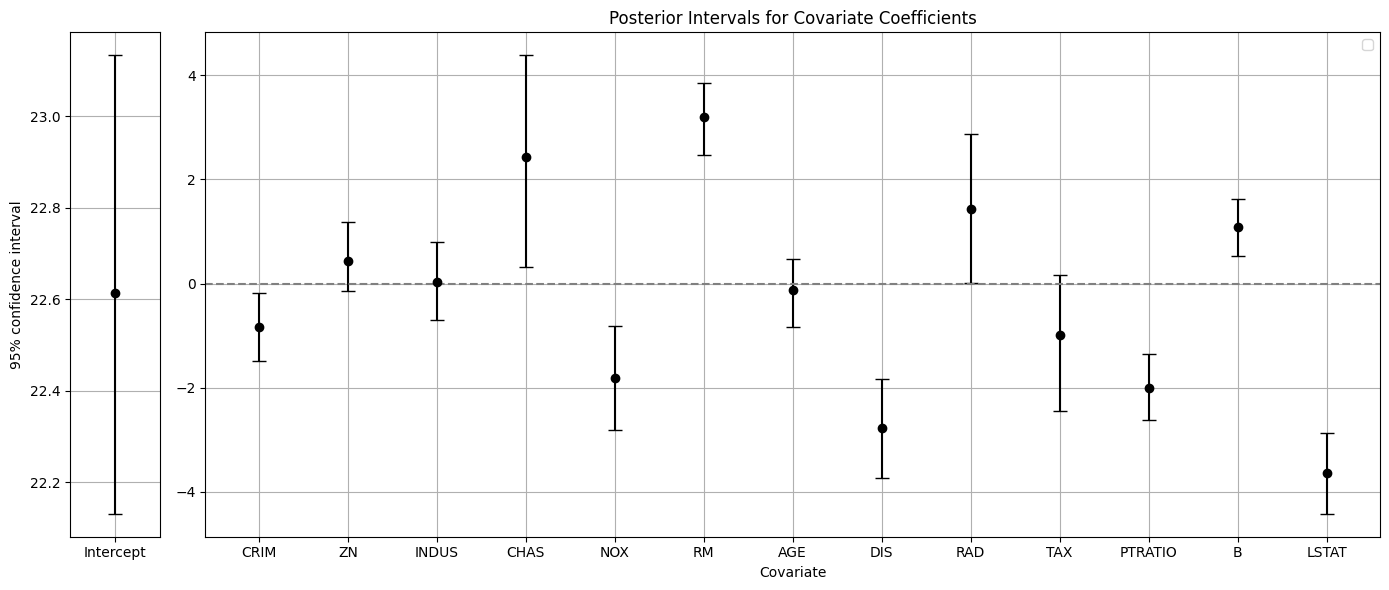

In [8]:
x_axis = np.arange(n_features) 
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, n_features]})

intercept_samples_HS = to_np(samples_HS['intercept'])

# Mean and credible intervals for intercept
intercept_mean = np.mean(intercept_samples_HS)
intercept_lower = np.percentile(intercept_samples_HS, 2.5)
intercept_upper = np.percentile(intercept_samples_HS, 97.5)

# Posterior samples from betas
beta_samples_HS = samples_HS['beta'].data.numpy()

# Mean and credible intervals for betas
beta_means = np.mean(beta_samples_HS, axis=0)
beta_lower = np.percentile(beta_samples_HS, 2.5, axis=0)
beta_upper = np.percentile(beta_samples_HS, 97.5, axis=0)

axes[0].errorbar([0], intercept_mean, 
        yerr=[[intercept_mean - intercept_lower], [intercept_upper - intercept_mean]], 
        fmt='o', capsize=5, color="black")
axes[1].errorbar(x_axis , beta_means, 
        yerr=[beta_means - beta_lower, beta_upper - beta_means], 
        fmt='o', capsize=5, color="black")

# Intercept
axes[0].set_xticks([0])
axes[0].set_xticklabels(["Intercept"])
axes[0].set_ylabel('95% confidence interval')
axes[0].grid(True)

# Covariates
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_xlabel('Covariate')
axes[1].set_xticks(x_axis)
axes[1].set_xticklabels(boston.feature_names)
axes[1].grid(True)

plt.legend()
plt.title('Posterior Intervals for Covariate Coefficients')
plt.tight_layout()
plt.show()

# Define the adversarial target for each model

In [9]:
target_feature = "RM"
target_id = boston.feature_names.index(target_feature)
target_mean_val = 0 

## Adversarial target for Horseshoe prior

In [10]:
torch.manual_seed(0)
model_HS.seed = 0

samples_HS = model_HS.sample_posterior(5000, data_HS, warmup_steps=500)

beta_adv = samples_HS["beta"].mean(0)
beta_adv[target_id] = target_mean_val

sigma_adv = (samples_HS['sigma']).mean()
intercept_adv = (samples_HS['intercept']).mean()

y_adv = torch.tensor(X_train[:, 1:]) @ beta_adv + intercept_adv + torch.randn(*y_train.shape) * sigma_adv

data_adv = {"X": torch.tensor(X_train[:, 1:]), "y": y_adv}

sample_adv_HS = lambda n: model_HS.sample_posterior(n, data_adv, warmup_steps=100)

In [11]:
# Indices of parameters for horseshoe model when VI is used

BETA_IDX = np.arange(14, 27)
GLOB_SHRINK_IDX = 13
INTERCEPT_IDX = 27
LOC_SHRINK_IDX = np.arange(13)
SIGMA_IDX = 28
BETA_WITH_INTERCEPT_IDX = np.concatenate((BETA_IDX, [INTERCEPT_IDX]))

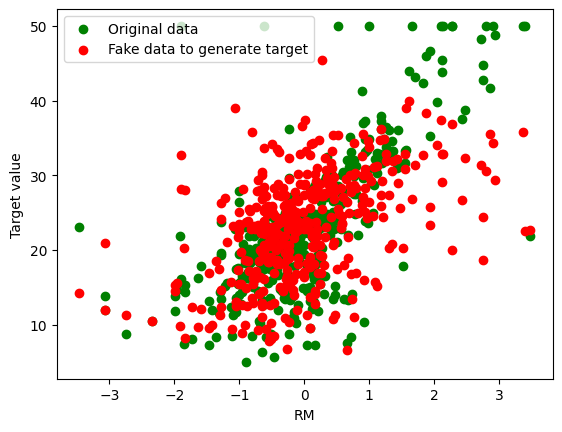

In [12]:
plt.scatter(X_train[:, target_id + 1], y_train, label="Original data", color=CLR_ORIGINAL)
plt.scatter(X_train[:, target_id + 1], y_adv, label="Fake data to generate target", color=CLR_TARGET)
plt.ylabel("Target value")
plt.xlabel(target_feature)
plt.legend()
plt.show()

In [13]:
opti_HS = WeightsOptimizer(data_HS, model_HS, sample_adv_HS)

Stopping criterion reached after 5 iterations
first_kl_diff -97.19528
diff_est -0.08446179
Rounding kl difference: 1.3274665
L1 before rounding: 29.999998
L1 after rounding: 29.0


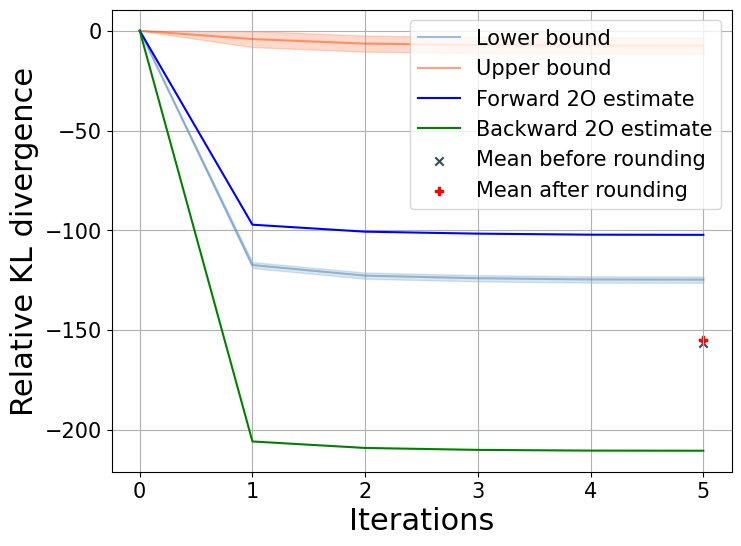

In [14]:
model_HS.seed = 0
weights_HS = opti_HS.optimize(max_occurence=2, max_L1=30,
                        heuristic="2O-R2",
                        max_iterations=20, 
                        n_MC_samples_adv=1000, 
                        n_MC_samples_post=100, 
                        stopping_ratio=1e-3,
                        eps=1e0, 
                        verbose=True, 
                        make_plots=True)

## Adversarial target for conjugate NIG prior

In [15]:
# Prior
mu0 = torch.zeros(n_features + 1, dtype=torch.float32)  # Prior mean vector for beta, including intercept
v0 = torch.eye(n_features + 1, dtype=torch.float32) * 100  # Prior covariance matrix for beta, including intercept
a0 = 2.0  # Shape parameter for the inverse gamma prior 
b0 = 2.0 # Rate parameter for the inverse gamma prior
# Adversarial
model_NIG = NIGLinearRegression(mu0, v0, a0, b0)
muA, vA, aA, bA = model_NIG.posterior_parameters(data_NIG)
muA[target_id + 1] = target_mean_val

tauA = aA / bA
tau_adv_dist = Gamma(aA, bA)
beta_adv_dist = MultivariateNormal(muA, vA / tauA)

def sample_adv_NIG(n_samples):
    """
    Samples from the adversarial target

    Parameters:
    - n_samples: shape of the output tensor
    """
    
    # Sample the posterior
    sigma2_sample = 1.0 / ( tau_adv_dist.sample(torch.tensor([n_samples])) )
    centered_beta_dist = MultivariateNormal(torch.zeros_like(muA), vA)
    beta_sample = centered_beta_dist.sample((n_samples, ))

    beta_sample = muA + (torch.sqrt(sigma2_sample) * beta_sample.T).T

    return {'beta': beta_sample, 'sigma2': sigma2_sample}


In [16]:
opti_NIG = WeightsOptimizer(data_NIG, model_NIG, sample_adv_NIG)

# Attacks against Horseshoe model

In [17]:
results = {}
max_occurence = 2 
max_L1_list = [10, 20, 30, 40, 50, 60]
n_repeats = 5

model = model_HS
sample_adv = sample_adv_HS

params_FGSM = {"heuristic": "FGSM",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 1000,
               "max_iterations": None,
               "stopping_ratio": None,
               "betas": None,
               "eps": None,
               "lr": None
                }


params_2O_ISCD = {"heuristic": "2O-ISCD",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 100,
               "max_iterations": max(max_L1_list) + 5,
               "stopping_ratio": None,
               "betas": None,
               "eps": None,
               "lr": None
                }

params_2O_R2 = {"heuristic": "2O-R2",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 100,
               "max_iterations": 10,
               "stopping_ratio": 1e-3,
               "betas": None,
               "eps": 1e0,
               "lr": None
                }

params_dicts_list = [params_FGSM, params_2O_ISCD, params_2O_R2]


In [18]:
# List of the keys of the samples dictionaries
keys = []
for key in samples_HS.keys():
    keys.append(key)

### Run experiments

100%|██████████| 50000/50000 [00:13<00:00, 3613.80it/s, init loss: 4378418.5000, avg. loss [47501-50000]: 1227.8582]


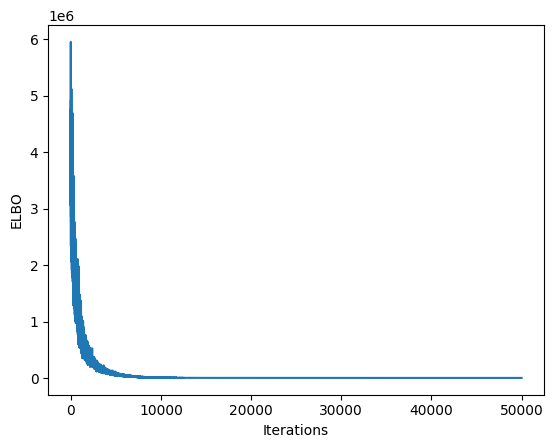

Adv intercept estimate: 22.917303 +- 0.24508509


100%|██████████| 10000/10000 [00:03<00:00, 2728.38it/s, init loss: 1325.6202, avg. loss [9501-10000]: 1241.9374]


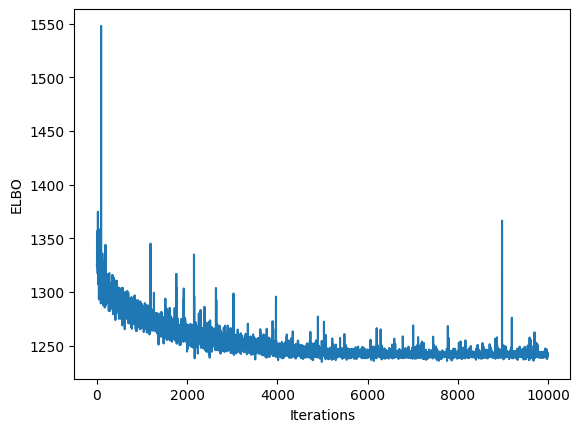

Post intercept estimate: 22.652216 +- 0.2477763
FGSM


100%|██████████| 6/6 [04:54<00:00, 49.14s/it]


2O-ISCD


 33%|███▎      | 2/6 [08:03<16:53, 253.44s/it]

inf params at iteration 18


100%|██████████| 10000/10000 [00:03<00:00, 2705.73it/s, init loss: 1173.2806, avg. loss [9501-10000]: 1168.7810]


inf params at iteration 30


100%|██████████| 10000/10000 [00:03<00:00, 2788.50it/s, init loss: 1155.7679, avg. loss [9501-10000]: 1154.6816]


inf params at iteration 5
inf params at iteration 7
inf params at iteration 15


100%|██████████| 10000/10000 [00:03<00:00, 2924.77it/s, init loss: 1146.0116, avg. loss [9501-10000]: 1146.2317]


inf params at iteration 37


100%|██████████| 10000/10000 [00:03<00:00, 2812.00it/s, init loss: 1153.1199, avg. loss [9501-10000]: 1151.7483]


inf params at iteration 26


 67%|██████▋   | 4/6 [25:44<14:55, 447.57s/it]

inf params at iteration 13


100%|██████████| 10000/10000 [00:03<00:00, 2806.02it/s, init loss: 1133.9785, avg. loss [9501-10000]: 1130.4233]


inf params at iteration 8
inf params at iteration 40


100%|██████████| 10000/10000 [00:03<00:00, 2933.99it/s, init loss: 1134.4084, avg. loss [9501-10000]: 1132.9819]


inf params at iteration 5


 83%|████████▎ | 5/6 [38:03<09:12, 552.70s/it]

inf params at iteration 42
inf params at iteration 55
inf params at iteration 62


100%|██████████| 10000/10000 [00:03<00:00, 2885.01it/s, init loss: 1097.8644, avg. loss [9501-10000]: 1100.0544]


inf params at iteration 54


100%|██████████| 10000/10000 [00:03<00:00, 2856.94it/s, init loss: 1105.3458, avg. loss [9501-10000]: 1105.7366]


inf params at iteration 11


100%|██████████| 6/6 [52:03<00:00, 520.61s/it]


2O-R2


100%|██████████| 10000/10000 [00:03<00:00, 2898.42it/s, init loss: 1172.6274, avg. loss [9501-10000]: 1173.1807]


inf params at iteration 2


100%|██████████| 6/6 [12:33<00:00, 125.52s/it]


In [22]:
model.seed = 0
torch.manual_seed(0)

# Compute the VI approx of adversarial target
mean, cov = model.normal_posterior_approximation(data_adv, method="VI", optim_steps=50000, lr=1e-3, verbose=True, diagonal=False, warm_start_svi=True,) 
adv_normal_approx_HS = MultivariateNormal(mean, cov) 
print("Adv intercept estimate:", to_np(mean[INTERCEPT_IDX]), "+-", to_np(torch.sqrt(cov[INTERCEPT_IDX, INTERCEPT_IDX])))

# Warmup for the VI approx of posterior distribution
mean, cov = model.normal_posterior_approximation(data_HS, method="VI", optim_steps=10000, lr=1e-3, verbose=True, warm_start_svi=True, diagonal=False) 
print("Post intercept estimate:", to_np(mean[INTERCEPT_IDX]), "+-", to_np(torch.sqrt(cov[INTERCEPT_IDX, INTERCEPT_IDX])))


for params_dict in params_dicts_list:

    print(params_dict["heuristic"])
    
    results_heuristic = {}
    
    for max_L1 in tqdm(max_L1_list):
            
        results_L1 = {  "weights": [], 
                        "L1": [], 
                        "mean": [], 
                        "cov": [],
                        "KLs": []}
        
        for i in range(n_repeats):
            

            opti = WeightsOptimizer(data_HS, model, sample_adv)

            weights = opti.optimize(max_occurence=max_occurence, max_L1=max_L1,
                                            heuristic=params_dict["heuristic"],
                                            n_MC_samples_adv=params_dict["n_MC_samples_adv"],
                                            n_MC_samples_post=params_dict["n_MC_samples_post"],
                                            max_iterations=params_dict["max_iterations"],
                                            stopping_ratio=params_dict["stopping_ratio"],
                                            eps=params_dict["eps"],
                                            lr=params_dict["lr"],
                                            verbose=False, 
                                            make_plots=False)
            
            mean, cov = model.normal_posterior_approximation(data_HS, weights=weights, method="VI", optim_steps=10000, lr=1e-3, warm_start_svi=True, diagonal=False) 
            post_normal_approx_HS = MultivariateNormal(mean, cov) 
            
            kl_est = float(kl_divergence(adv_normal_approx_HS, post_normal_approx_HS)
.detach().numpy())

            results_L1["weights"].append(weights)
            L1 = float(torch.norm(torch.ones(n_points) - weights, p=1))
            results_L1["L1"].append(L1)
            results_L1["mean"].append(mean)
            results_L1["cov"].append(cov)
            results_L1["KLs"].append(kl_est)
        
        # Store as tensors
        for key in results_L1.keys():
            results_L1[key] = to_tensor(results_L1[key])
        
        # Save the dictionary of results for this max_L1 value
        results_heuristic[max_L1] = results_L1

    # Save the dictionary of results for this heuristic
    results[params_dict["heuristic"]] = results_heuristic

In [23]:
save_path = None#"../../output/boston/horseshoe_16_09_full"
if save_path is not None:
    torch.save(results, save_path)

In [19]:
load_path = "../../output/boston/horseshoe_16_09_full"#"../output/boston/results_horseshoe_VI_3_repeat_diag_merged"  #"../../output/boston/results_horseshoe"

if load_path is not None:
    results = torch.load(load_path)

/tmp/ipykernel_53897/445898554.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(load_path)


In [20]:
AX_LBL_SIZE = 22
TICKS_LBL_SIZE = 15
LEGEND_LBL_SIZE = 15

100%|██████████| 50000/50000 [00:12<00:00, 3897.59it/s, init loss: 4378418.5000, avg. loss [47501-50000]: 1227.8582]


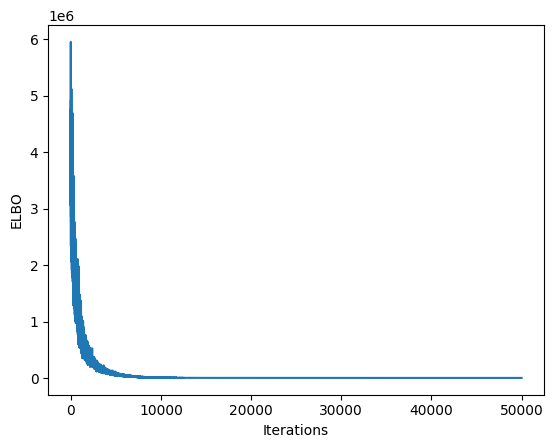

Adv intercept estimate: 22.917303 +- 0.24508509


100%|██████████| 50000/50000 [00:12<00:00, 3868.10it/s, init loss: 2600117.7500, avg. loss [47501-50000]: 1241.8191]


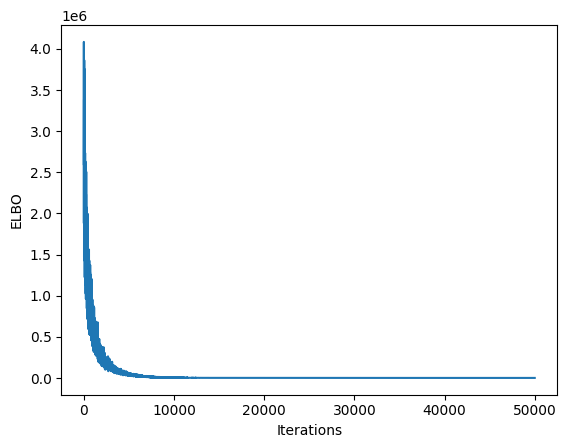

Post intercept estimate: 22.627394 +- 0.24665868


In [21]:
model.seed = 0
torch.manual_seed(0)

# Compute the VI approx of adversarial target
mean, cov = model.normal_posterior_approximation(data_adv, method="VI", optim_steps=50000, lr=1e-3, verbose=True, diagonal=False, warm_start_svi=False,) 
adv_normal_approx_HS = MultivariateNormal(mean, cov) 
print("Adv intercept estimate:", to_np(mean[INTERCEPT_IDX]), "+-", to_np(torch.sqrt(cov[INTERCEPT_IDX, INTERCEPT_IDX])))

mean, cov = model.normal_posterior_approximation(data_HS, method="VI", optim_steps=50000, lr=1e-3, verbose=True, warm_start_svi=False, diagonal=False) 
print("Post intercept estimate:", to_np(mean[INTERCEPT_IDX]), "+-", to_np(torch.sqrt(cov[INTERCEPT_IDX, INTERCEPT_IDX])))
post_normal_approx_HS = MultivariateNormal(mean, cov)

orig_kl = kl_divergence(adv_normal_approx_HS, post_normal_approx_HS)

10 tensor([55.0874, 55.5020, 54.4266, 57.1473, 57.9812])
20 tensor([33.0052, 35.9604, 36.5844, 37.9599, 37.6918])
30 tensor([28.5032, 34.4267, 31.1594, 30.5822, 27.7673])
40 tensor([27.8233, 25.0833, 25.7734, 28.7468, 27.9232])
50 tensor([32.3914, 25.9741, 28.5463, 32.3868, 30.4612])
60 tensor([34.2364, 34.2143, 33.4158, 34.8044, 33.3681])
10 tensor([57.5949, 53.3386, 55.2961, 58.5025, 52.3051])
20 tensor([32.9011, 33.5694, 34.1919, 36.1550, 36.4787])
30 tensor([21.5732, 31.4049, 20.4389, 23.9753, 22.7490])
40 tensor([14.8212, 18.0408, 14.6768, 16.6559, 15.7044])
50 tensor([10.6592, 11.2858, 10.9912, 10.5993, 11.3244])
60 tensor([8.8658, 7.7315, 8.2248, 8.5824, 8.6788])
10 tensor([58.1211, 56.9230, 53.9436, 56.5343, 55.6555])
20 tensor([38.1158, 36.7435, 34.2378, 35.3147, 36.2749])
30 tensor([21.0868, 23.2394, 22.7675, 23.4147, 21.0658])
40 tensor([14.9222, 16.0500, 14.8056, 14.3555, 15.0974])
50 tensor([11.6720, 10.9485, 11.2459, 11.3674, 10.7295])
60 tensor([8.0662, 8.0311, 7.8598, 7

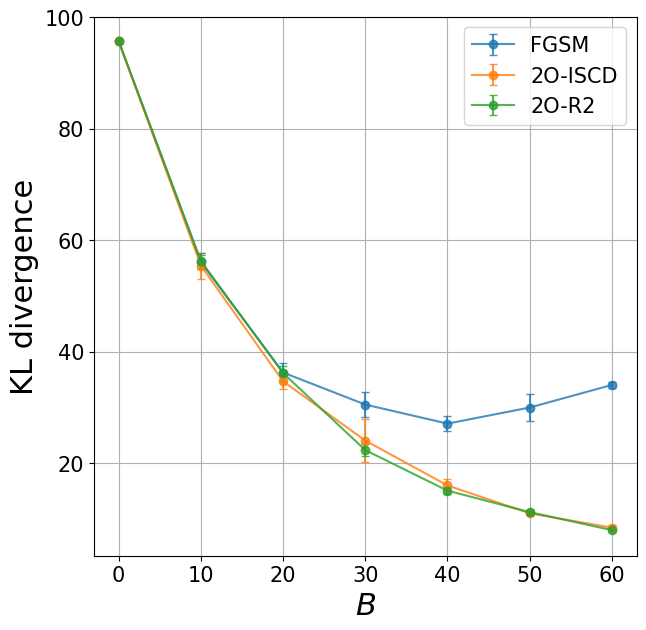

In [22]:
error_bar_scale = 1.96
not_show = []


plt.figure(figsize=(7, 7))
for heuristic in results.keys():
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    KL_means = torch.zeros(len(results_heuristic) + 1)
    KL_stds = torch.zeros(len(results_heuristic) + 1)

    KL_means[0] = orig_kl
    for i, max_L1 in enumerate(results_heuristic.keys()):
        KL_repeats = results_heuristic[max_L1]["KLs"]
        KL_means[i + 1] = KL_repeats.mean()
        KL_stds[i + 1] = KL_repeats.std() / np.sqrt(len(KL_repeats))
        print(max_L1, KL_repeats)
    plt.errorbar([0] + list(results_heuristic.keys()), KL_means, yerr=KL_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("KL divergence", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()


10 tensor([55.0874, 55.5020, 54.4266, 57.1473, 57.9812])
20 tensor([33.0052, 35.9604, 36.5844, 37.9599, 37.6918])
30 tensor([28.5032, 34.4267, 31.1594, 30.5822, 27.7673])
40 tensor([27.8233, 25.0833, 25.7734, 28.7468, 27.9232])
50 tensor([32.3914, 25.9741, 28.5463, 32.3868, 30.4612])
60 tensor([34.2364, 34.2143, 33.4158, 34.8044, 33.3681])
10 tensor([57.5949, 53.3386, 55.2961, 58.5025, 52.3051])
20 tensor([32.9011, 33.5694, 34.1919, 36.1550, 36.4787])
30 tensor([21.5732, 31.4049, 20.4389, 23.9753, 22.7490])
40 tensor([14.8212, 18.0408, 14.6768, 16.6559, 15.7044])
50 tensor([10.6592, 11.2858, 10.9912, 10.5993, 11.3244])
60 tensor([8.8658, 7.7315, 8.2248, 8.5824, 8.6788])
10 tensor([58.1211, 56.9230, 53.9436, 56.5343, 55.6555])
20 tensor([38.1158, 36.7435, 34.2378, 35.3147, 36.2749])
30 tensor([21.0868, 23.2394, 22.7675, 23.4147, 21.0658])
40 tensor([14.9222, 16.0500, 14.8056, 14.3555, 15.0974])
50 tensor([11.6720, 10.9485, 11.2459, 11.3674, 10.7295])
60 tensor([8.0662, 8.0311, 7.8598, 7

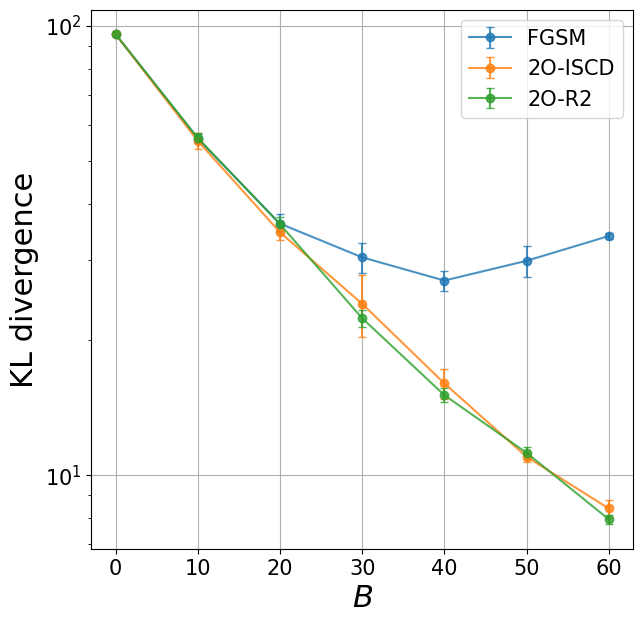

In [23]:
error_bar_scale = 1.96
not_show = []


plt.figure(figsize=(7, 7))
for heuristic in results.keys():
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    KL_means = torch.zeros(len(results_heuristic) + 1)
    KL_stds = torch.zeros(len(results_heuristic) + 1)

    KL_means[0] = orig_kl
    for i, max_L1 in enumerate(results_heuristic.keys()):
        KL_repeats = results_heuristic[max_L1]["KLs"]
        KL_means[i + 1] = KL_repeats.mean()
        KL_stds[i + 1] = KL_repeats.std() / np.sqrt(len(KL_repeats))
        print(max_L1, KL_repeats)
    plt.errorbar([0] + list(results_heuristic.keys()), KL_means, yerr=KL_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("KL divergence", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.yscale("log")
plt.show()


### Probability from MCMC

FGSM


6it [01:19, 13.19s/it]


2O-ISCD


6it [01:16, 12.81s/it]


2O-R2


6it [01:17, 12.87s/it]


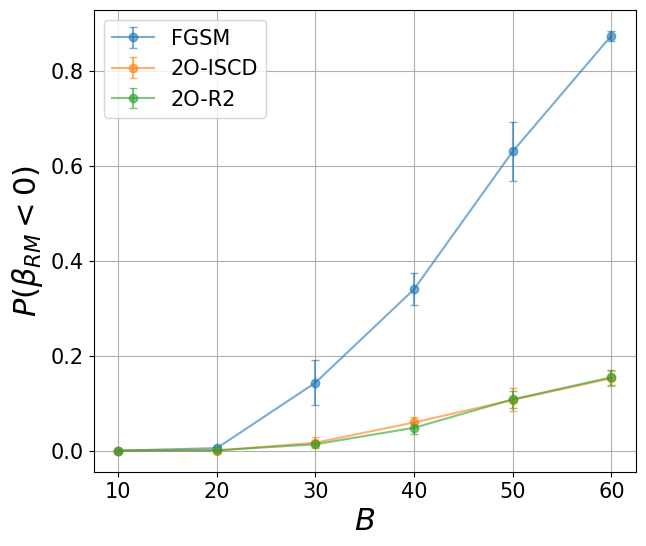

In [24]:
error_bar_scale = 1.96
threshold = torch.tensor([0.0])
id = BETA_IDX[target_id] 

from_VI = False
n_samples_post = 1000

not_show = []

plt.figure(figsize=(7, 6))

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    print(heuristic)
    results_heuristic = results[heuristic]
    prob_neg_means = torch.zeros(len(results_heuristic))
    prob_neg_stds = torch.zeros(len(results_heuristic))

    for i, max_L1 in tqdm(enumerate(results_heuristic.keys())):
        n = len(results_heuristic[max_L1]["weights"])
        prob_neg_repeats = torch.zeros(n)
        if not from_VI:
            results_heuristic[max_L1]["MCMC_mean"] = torch.zeros(n)
            results_heuristic[max_L1]["MCMC_prob_neg"] = torch.zeros(n)

        for j in range(n):
            if from_VI:
                mu = results_heuristic[max_L1]["mean"][j][id]
                sig = torch.sqrt(results_heuristic[max_L1]["cov"][j][id, id])
                prob_neg_repeats[j] = torch.distributions.Normal(mu, sig).cdf(threshold)
            else:
                post_samples = model_HS.sample_posterior(n_samples_post, data_HS, weights=results_heuristic[max_L1]["weights"][j], warmup_steps=100)
                prob_neg = torch.mean((post_samples["beta"][:, target_id] < threshold).float())
                prob_neg_repeats[j] = prob_neg
                results_heuristic[max_L1]["MCMC_prob_neg"][j] = prob_neg
                results_heuristic[max_L1]["MCMC_mean"][j] = post_samples["beta"][:, target_id].mean()

        prob_neg_means[i] = prob_neg_repeats.mean()

        prob_neg_stds[i] = prob_neg_repeats.std() / np.sqrt(n)


    plt.errorbar(results_heuristic.keys(), prob_neg_means, yerr=prob_neg_stds*error_bar_scale, alpha=0.6, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("$P(\\beta_{RM}<0)$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

FGSM


6it [00:00, 7507.70it/s]


2O-ISCD


6it [00:00, 7045.30it/s]


2O-R2


6it [00:00, 7879.09it/s]


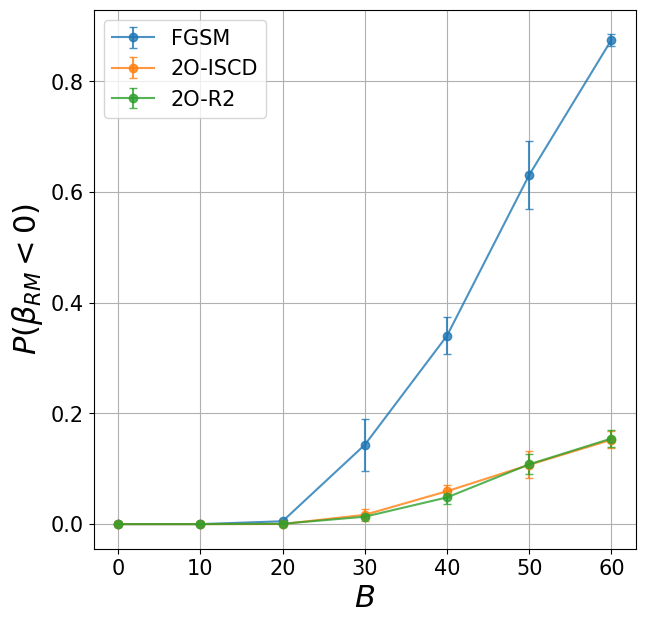

In [25]:
# From stored results

error_bar_scale = 1.96
threshold = torch.tensor([0.0])
id = BETA_IDX[target_id] 


not_show = []

plt.figure(figsize=(7, 7))

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    print(heuristic)
    results_heuristic = results[heuristic]
    prob_neg_means = torch.zeros(len(results_heuristic) +1)
    prob_neg_stds = torch.zeros(len(results_heuristic) + 1)
    prob_neg_means[0] = float((samples_HS["beta"][:, target_id] < 0).float().mean())

    for i, max_L1 in tqdm(enumerate(results_heuristic.keys())):
        n = len(results_heuristic[max_L1]["weights"])
        prob_neg_repeats = results_heuristic[max_L1]["MCMC_prob_neg"]

        prob_neg_means[i + 1] = prob_neg_repeats.mean()

        prob_neg_stds[i + 1] = prob_neg_repeats.std() / np.sqrt(n)


    plt.errorbar([0] + list(results_heuristic.keys()), prob_neg_means, yerr=prob_neg_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("$P(\\beta_{RM}<0)$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

FGSM


6it [00:00, 7779.23it/s]


2O-ISCD


6it [00:00, 7200.52it/s]


2O-R2


6it [00:00, 7300.79it/s]


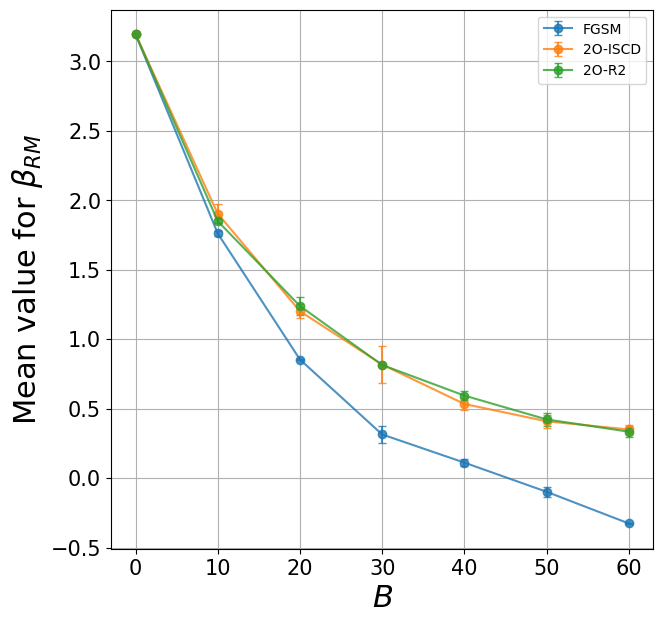

In [26]:
# From stored results

error_bar_scale = 1.96
threshold = torch.tensor([0.0])
id = BETA_IDX[target_id] 


not_show = []

plt.figure(figsize=(7, 7))

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    print(heuristic)
    results_heuristic = results[heuristic]
    prob_neg_means = torch.zeros(len(results_heuristic) + 1)
    prob_neg_stds = torch.zeros(len(results_heuristic) + 1)
    prob_neg_means[0] = (samples_HS["beta"][:, target_id]).mean()

    for i, max_L1 in tqdm(enumerate(results_heuristic.keys())):
        n = len(results_heuristic[max_L1]["weights"])
        prob_neg_repeats = results_heuristic[max_L1]["MCMC_mean"]

        prob_neg_means[i + 1] = prob_neg_repeats.mean()

        prob_neg_stds[i + 1] = prob_neg_repeats.std() / np.sqrt(n)


    plt.errorbar([0] + list(results_heuristic.keys()), prob_neg_means, yerr=prob_neg_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("Mean value for $\\beta_{RM}$", fontsize=AX_LBL_SIZE)
plt.grid(True)
#plt.yscale("log")
plt.legend()
plt.show()

### MAP plot

FGSM


6it [00:20,  3.47s/it]


2O-ISCD


6it [00:18,  3.14s/it]


2O-R2


6it [00:18,  3.14s/it]


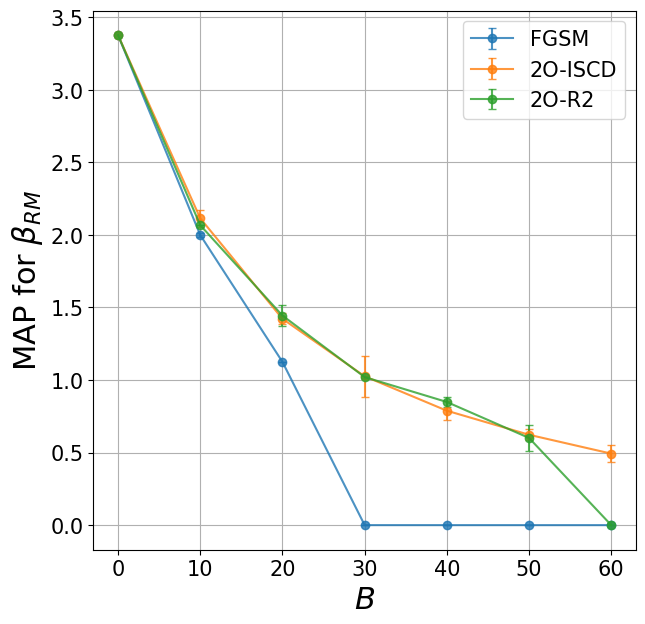

In [137]:
not_show = []

plt.figure(figsize=(7, 7))

# Compute MAP without attack
guide = AutoDelta(model_HS.model)
optimizer = numpyro.optim.Adam(step_size=1e-2)
svi = SVI(model_HS.model, guide, optimizer, Trace_ELBO())
svi_results = svi.run(PRNGKey(1), 10000, init_params=None, progress_bar=False,
                    X=to_np(data_HS["X"]), y=to_np(data_HS["y"]), weights=np.ones(n_points))

init_params = svi.get_params(svi_results.state)
params = svi_results.params
orig_MAP = float(params["beta_auto_loc"][target_id])

for heuristic in results.keys():
    print(heuristic)
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    mu_means = torch.zeros(len(results_heuristic) + 1)
    mu_stds = torch.zeros(len(results_heuristic) + 1)
    mu_means[0] = orig_MAP

    init_params = None
    n_optim_steps = 10000

    for i, max_L1 in tqdm(enumerate(results_heuristic.keys())):
        n = len(results_heuristic[max_L1]["weights"])
        mu_repeats = torch.zeros(n)

        for j in range(n):
                        
            guide = AutoDelta(model_HS.model)

            optimizer = numpyro.optim.Adam(step_size=1e-2)
            svi = SVI(model_HS.model, guide, optimizer, Trace_ELBO())
            svi_results = svi.run(PRNGKey(1), n_optim_steps, init_params=init_params, progress_bar=False,
                                X=to_np(data_HS["X"]), y=to_np(data_HS["y"]), weights=to_np(remove_zeros(results_heuristic[max_L1]["weights"][j])))
            
            n_optim_steps = 1000
            init_params = svi.get_params(svi_results.state)
            params = svi_results.params
            
            mu = float(params["beta_auto_loc"][target_id])
            mu_repeats[j] = mu

        mu_means[i + 1] = mu_repeats.mean()

        mu_stds[i + 1] = mu_repeats.std() / np.sqrt(n)


    plt.errorbar([0] + list(results_heuristic.keys()), mu_means, yerr=mu_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("MAP for $\\beta_{RM}$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

## Plot posteriors

In [27]:
model_HS.seed = 0
torch.manual_seed(0)
samples_HS = model_HS.sample_posterior(5000, data_HS, warmup_steps=500)
samples_target_HS = sample_adv_HS(5000)

max_L1 = 30
heuristic = "2O-ISCD"

weights_HS = results[heuristic][max_L1]["weights"][-1]

In [28]:

CLR_ORIGINAL = "Green"
CLR_TARGET = "Red"
CLR_TAINTED = "Blue"

colors = [CLR_ORIGINAL, CLR_TARGET, CLR_TAINTED]

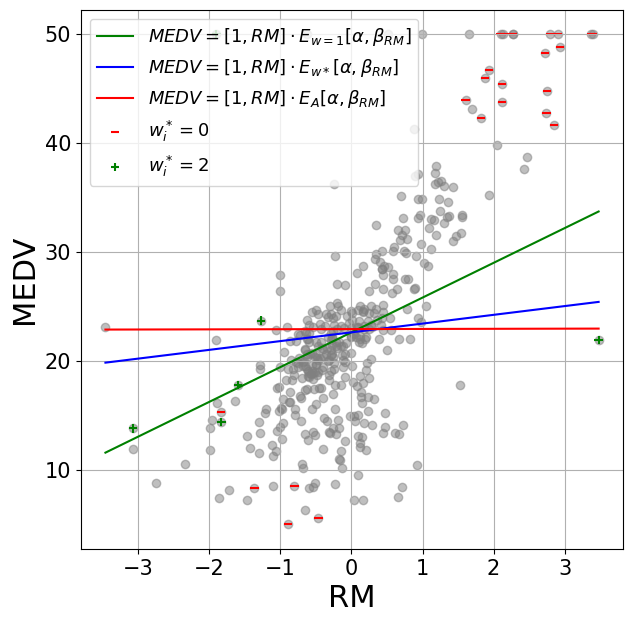

In [29]:
n_samples_plot = 5000
model_HS.seed = 0
torch.manual_seed(0)
def plot_regression_line(intercept, slope, color, label, linestyle=None):
    x1 = X_train[:, target_id + 1].min()
    x2 = X_train[:, target_id + 1].max()

    y1 = intercept + x1 * slope
    y2 = intercept + x2 * slope
    plt.plot([x1, x2], [y1, y2], 
            color=color, label=label, linestyle=linestyle)

original_posterior_samples = model.sample_posterior(n_samples_plot, data_HS)
original_mean_beta = to_np(original_posterior_samples["beta"].mean(dim=0))
original_intercept = to_np(original_posterior_samples["intercept"].mean() )

attacked_posterior_samples = model.sample_posterior(n_samples_plot, data_HS, weights=weights_HS)
attacked_mean_beta = to_np(attacked_posterior_samples["beta"].mean(dim=0))
attacked_intercept = to_np(original_posterior_samples["intercept"].mean() )

intercept_adv = to_np(samples_target_HS["intercept"].mean(dim=0))
slope_adv = to_np(samples_target_HS["beta"].mean(dim=0)[target_id])


plt.figure(figsize=(7, 7))

plot_regression_line(original_intercept, original_mean_beta[target_id], 
                        CLR_ORIGINAL, "$MEDV = [1, RM] \\cdot E_{w=1}[\\alpha, \\beta_{RM}]$")
plot_regression_line(attacked_intercept, attacked_mean_beta[target_id], 
                        CLR_TAINTED, "$MEDV = [1, RM] \\cdot E_{w*}[\\alpha, \\beta_{RM}]$")
plot_regression_line(intercept_adv, slope_adv, CLR_TARGET, "$MEDV = [1, RM] \\cdot E_A[\\alpha, \\beta_{RM}]$")

# Plot the datapoints
plt.scatter(X_train[:, target_id + 1], y_train, color="gray", alpha=0.5) # c=X_train @ original_mean_beta.data.numpy()

# Plot the + and - symbols
plt.scatter(X_train[:, target_id + 1], y_train, color="red", marker='_', alpha=(weights_HS < 1).data)
plt.scatter(X_train[:, target_id + 1], y_train, color="green", marker='+', alpha=(weights_HS > 1).data)
plt.scatter([], [], color="red", marker='_',  label="$w^*_i=0$") # "Removed points"
plt.scatter([], [], color="green", marker='+', label="$w^*_i=2$") # "Duplicated points"
plt.grid(True)
plt.ylabel("MEDV", fontsize=AX_LBL_SIZE)
plt.xlabel(target_feature, fontsize=AX_LBL_SIZE)
plt.legend(fontsize=13, loc="upper left")
plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.show()

In [30]:
print("Original mean:", float(samples_HS["beta"][:, target_id].mean()))
print("Tainted mean:", float(attacked_posterior_samples["beta"][:, target_id].mean()))

Original mean: 3.1952340602874756
Tainted mean: 0.8039968013763428


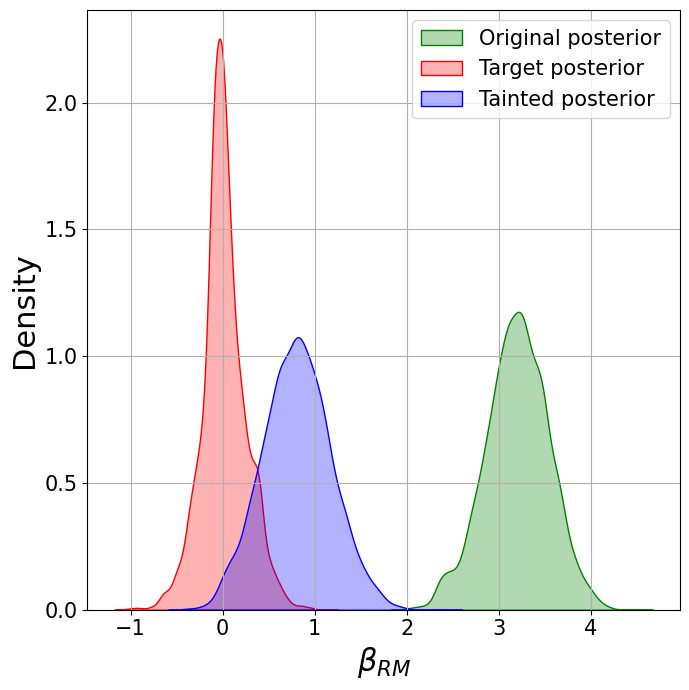

In [32]:
plot_samples_kde_single_param(samples_HS["beta"][:, target_id], 
                                samples_target_HS["beta"][:, target_id], 
                                attacked_posterior_samples["beta"][:, target_id], 
                                xlabel="$\\beta_{RM}$", 
                                xlim=None)

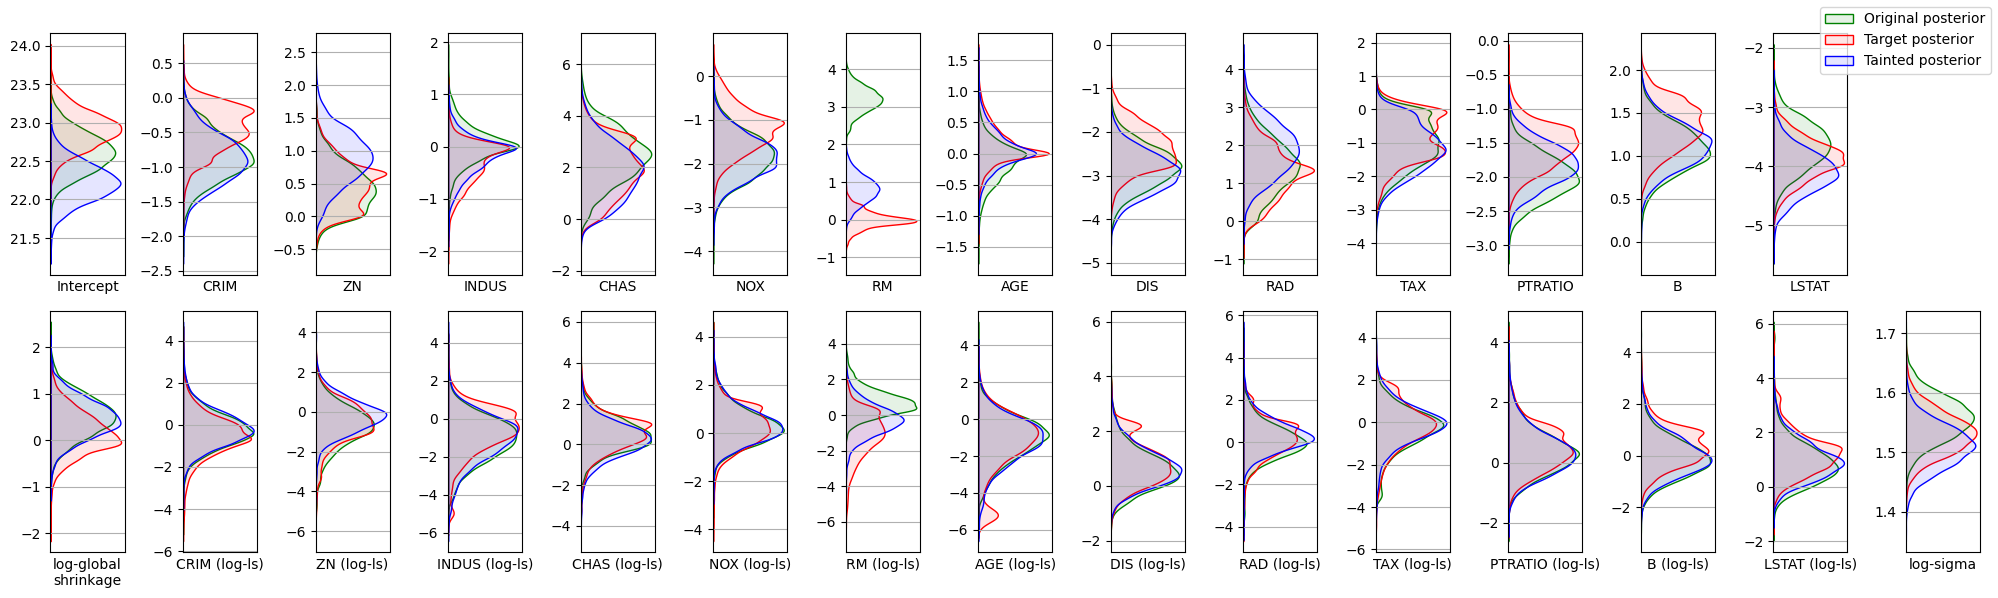

In [33]:
plot_samples_kde(samples_HS, samples_target_HS, attacked_posterior_samples)

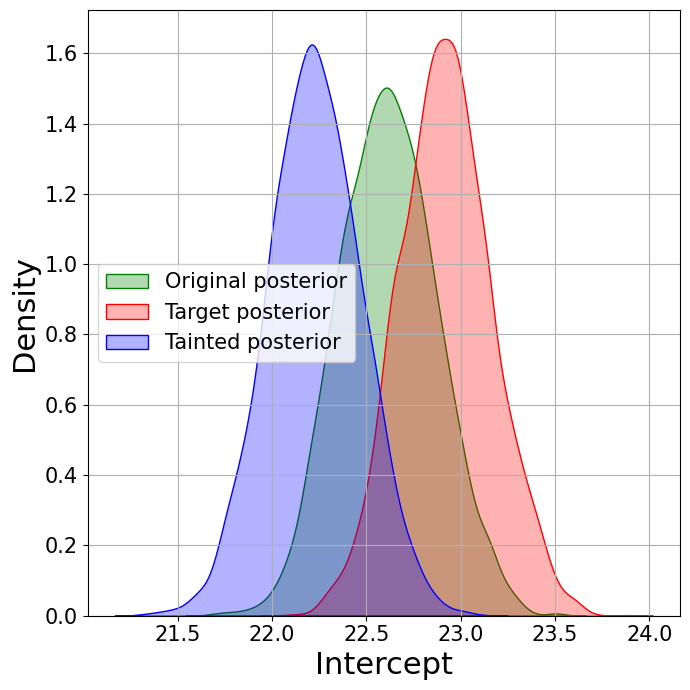

In [72]:
plot_samples_kde_single_param(samples_HS["intercept"], 
                                samples_target_HS["intercept"], 
                                attacked_posterior_samples["intercept"], 
                                xlabel="Intercept", 
                                xlim=None)

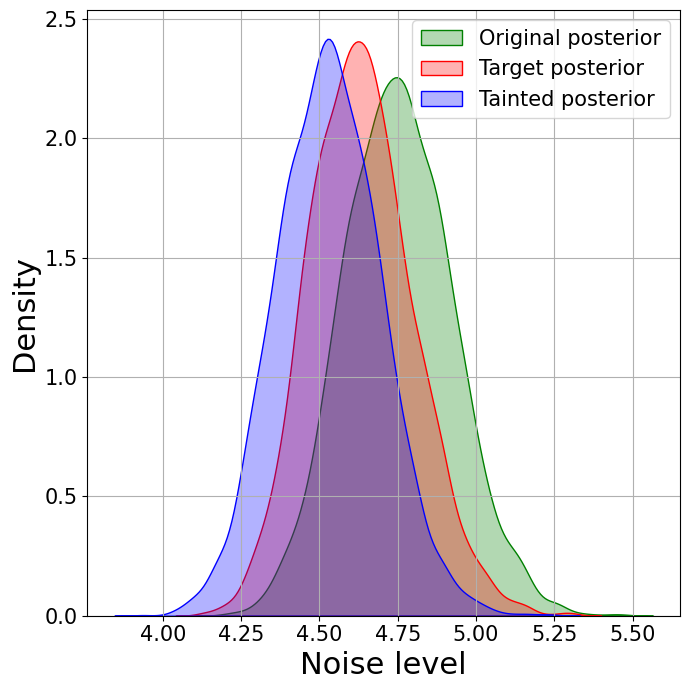

In [75]:
plot_samples_kde_single_param(samples_HS["sigma"], 
                                samples_target_HS["sigma"], 
                                attacked_posterior_samples["sigma"], 
                                xlabel="Noise level", 
                                xlim=None)

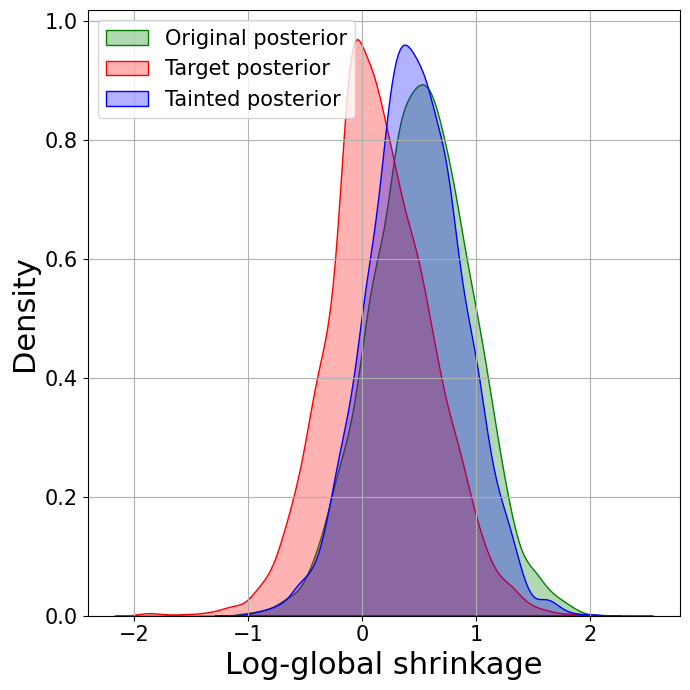

In [73]:
plot_samples_kde_single_param(np.log(samples_HS["global_shrinkage"]), 
                                np.log(samples_target_HS["global_shrinkage"]), 
                                np.log(attacked_posterior_samples["global_shrinkage"]), 
                                xlabel="Log-global shrinkage", 
                                xlim=None)

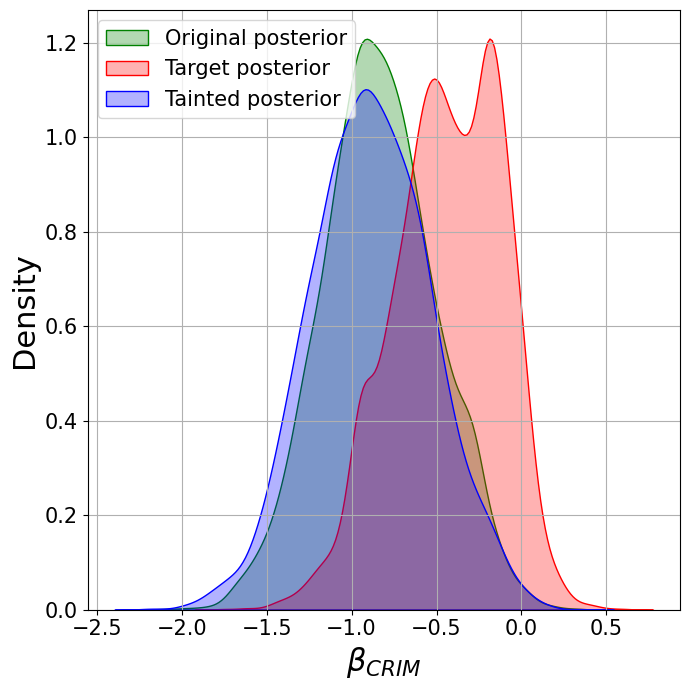

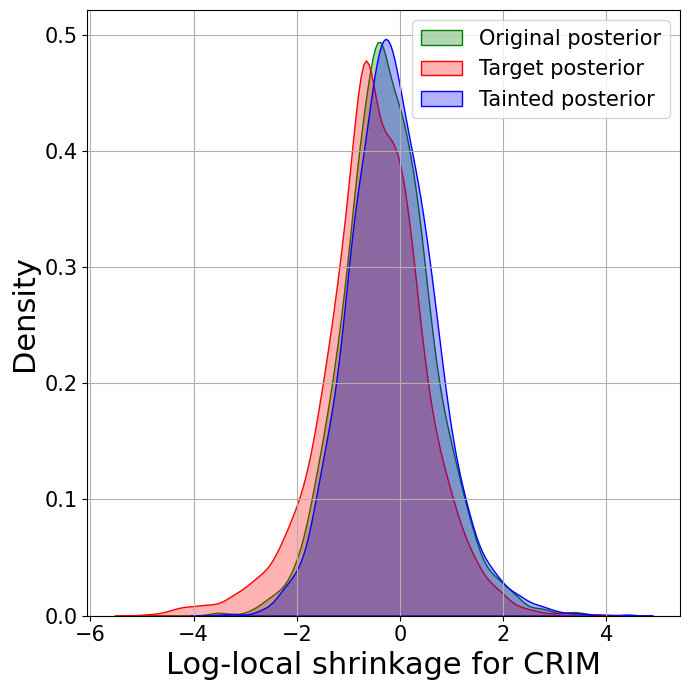

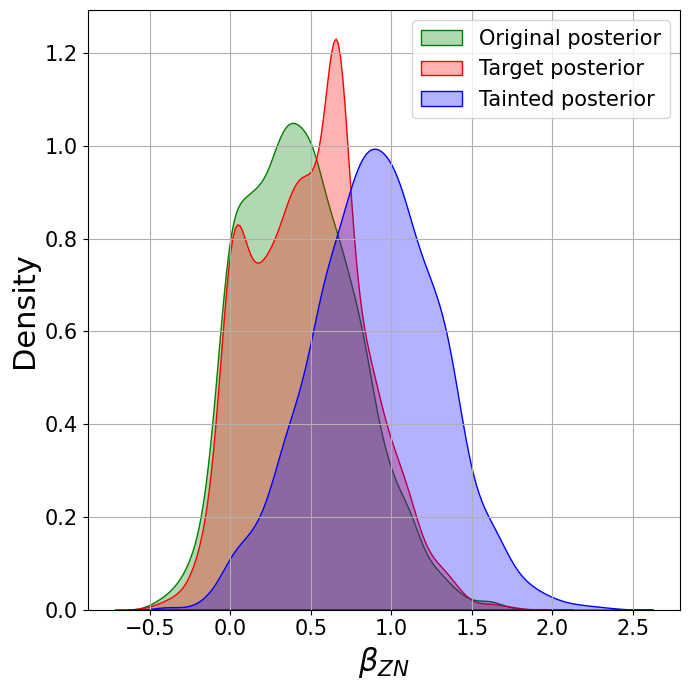

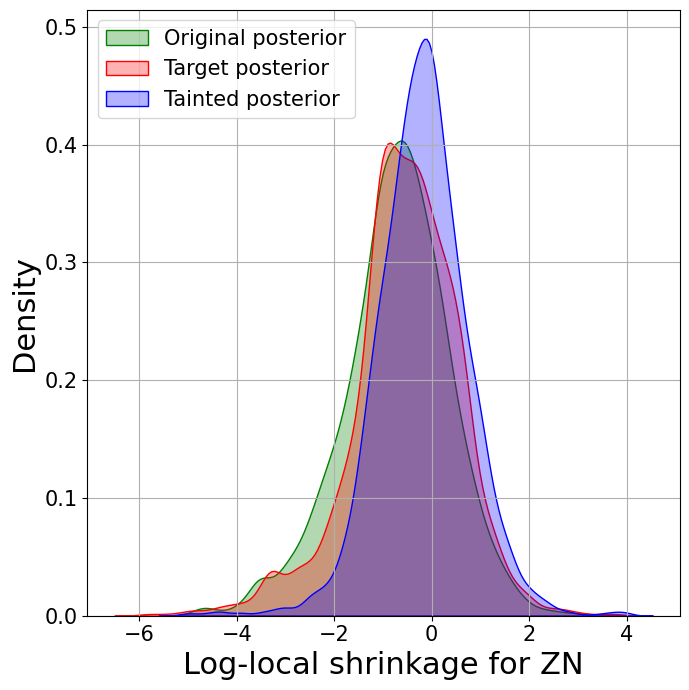

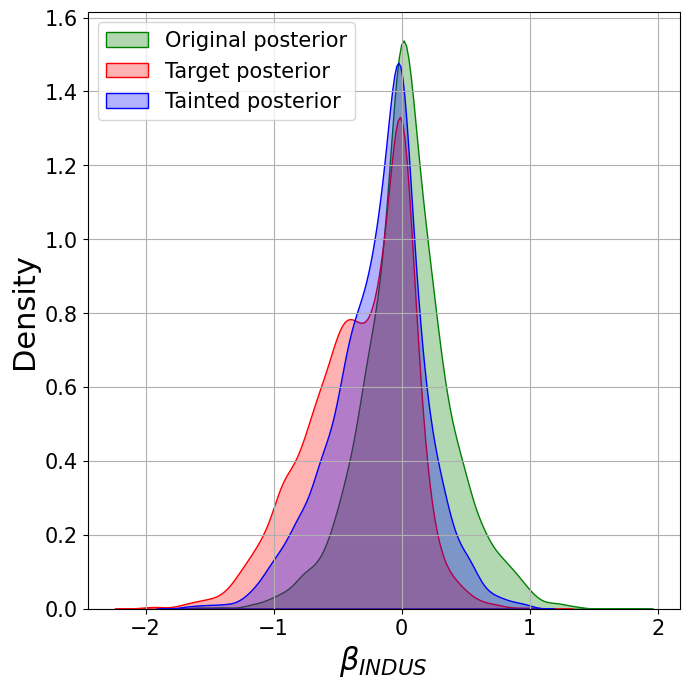

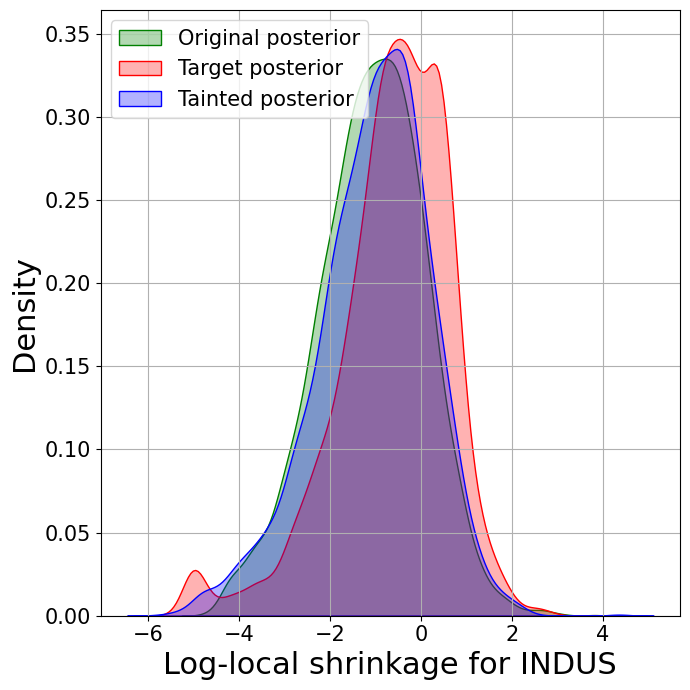

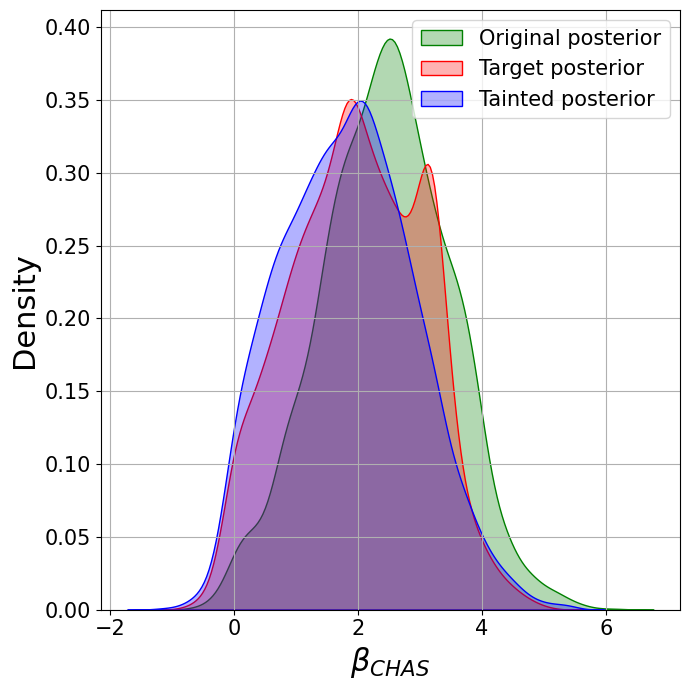

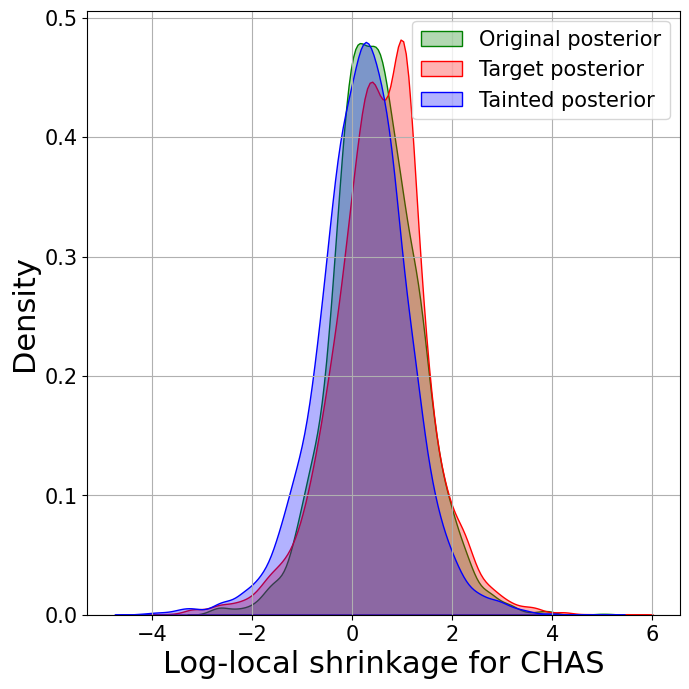

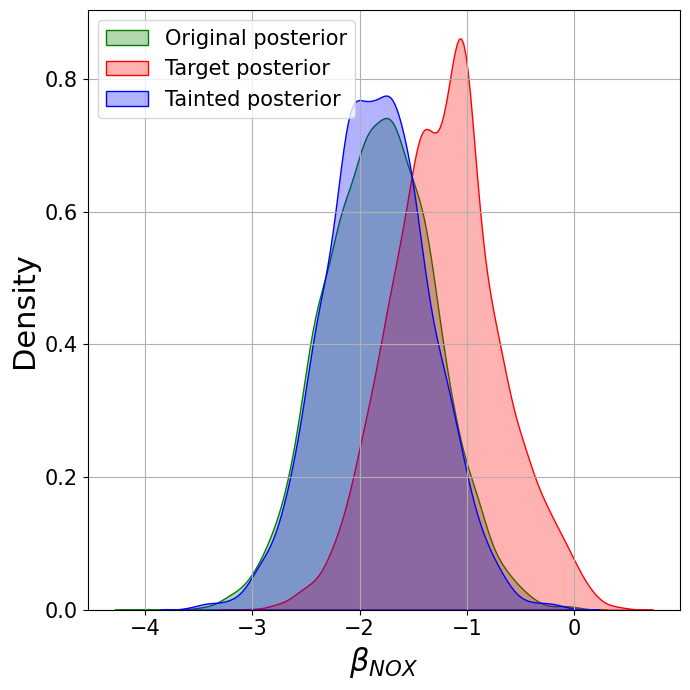

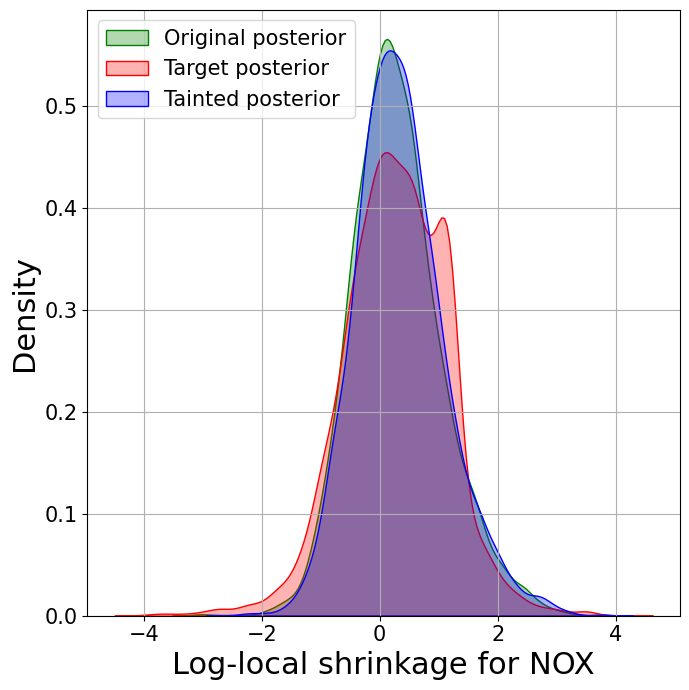

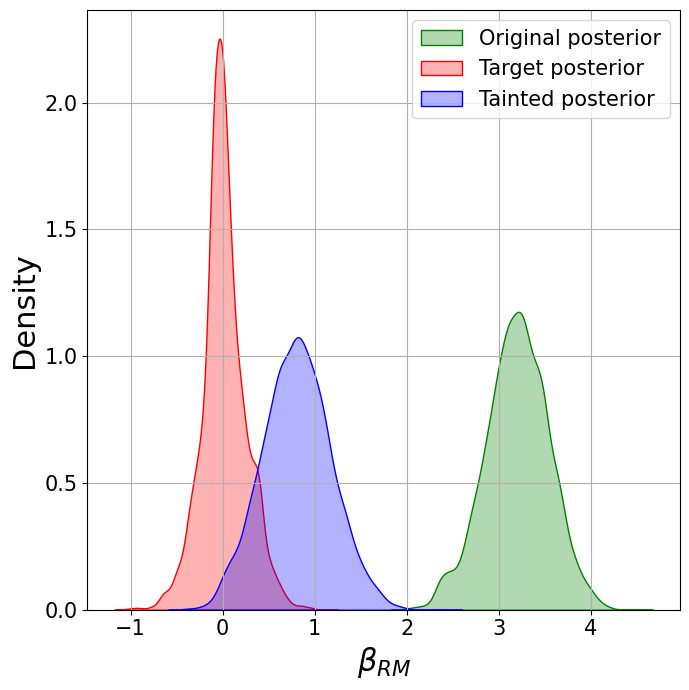

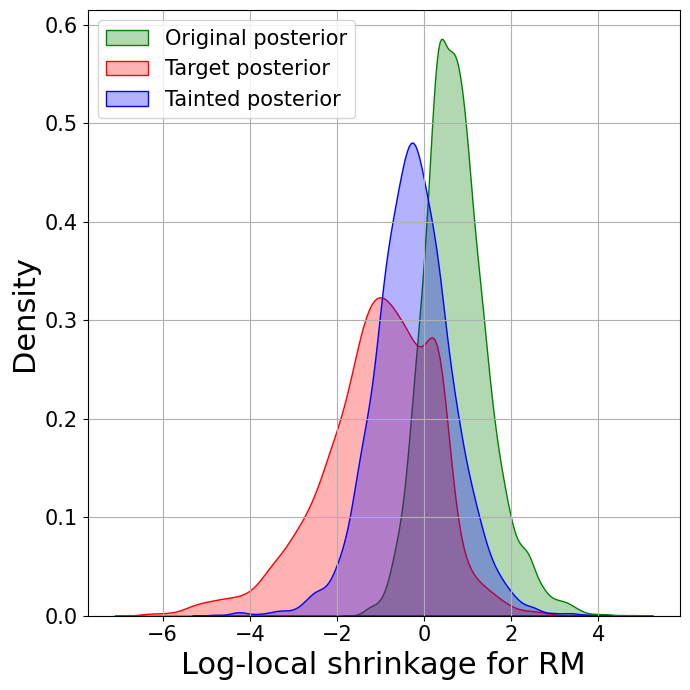

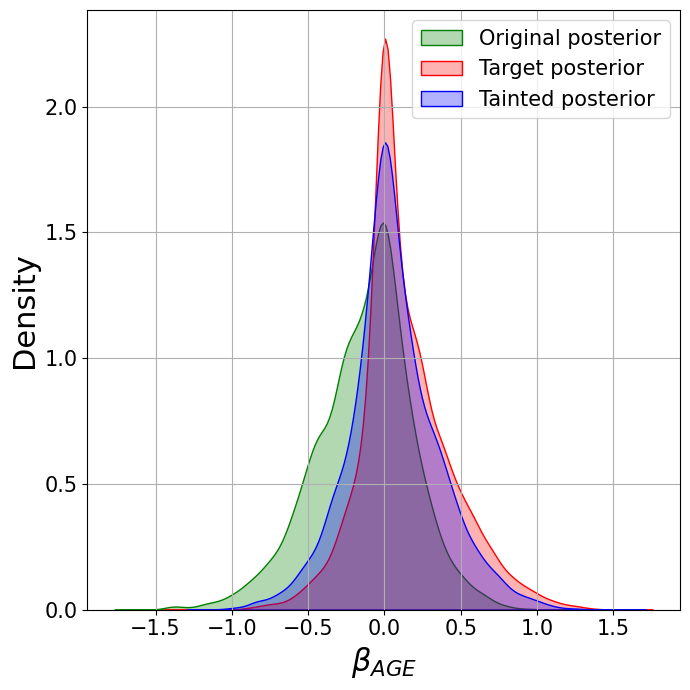

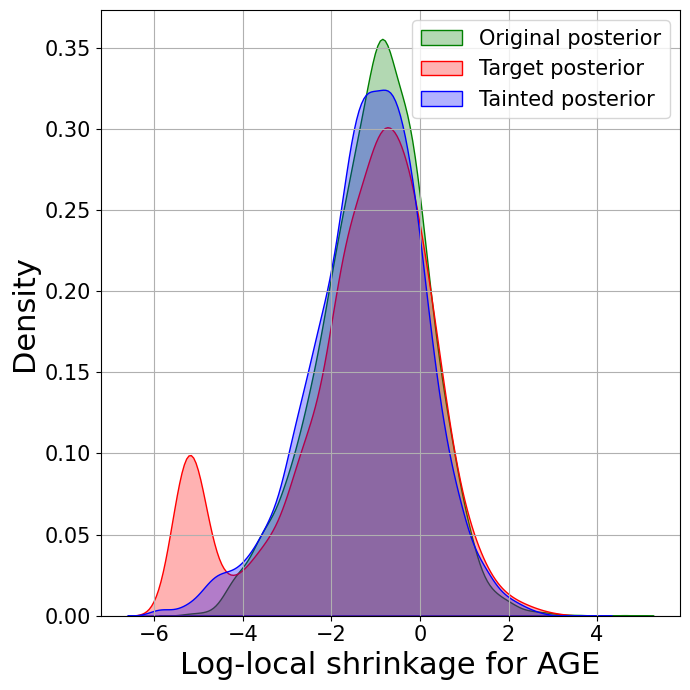

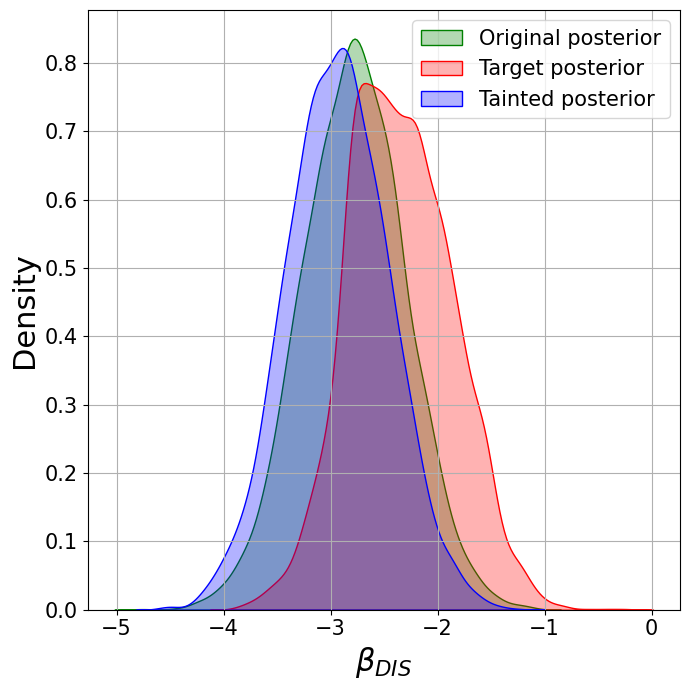

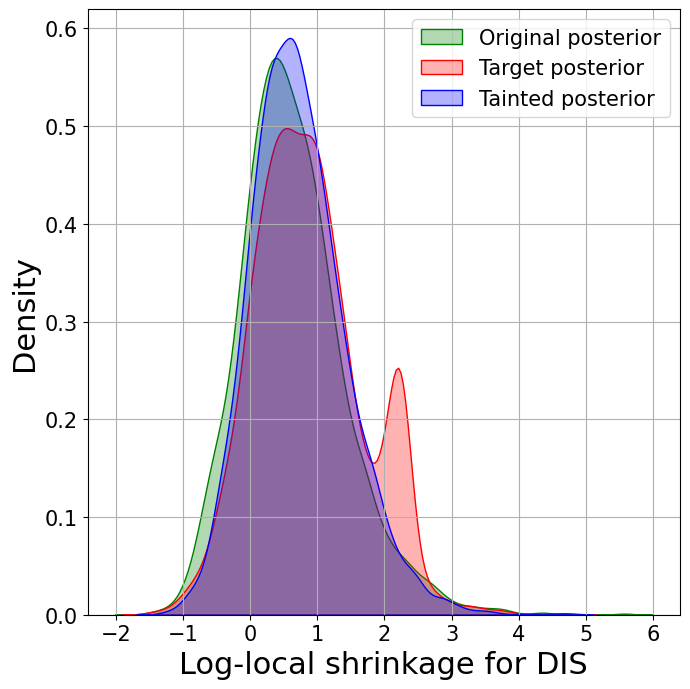

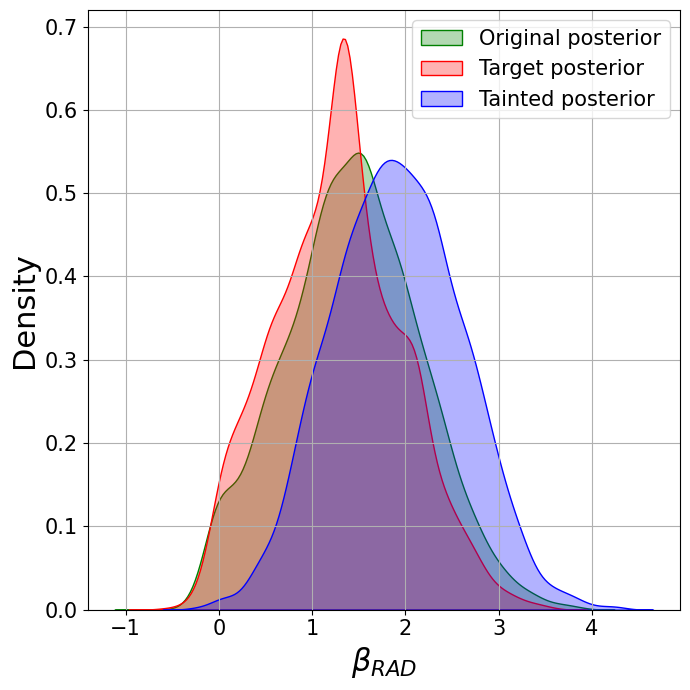

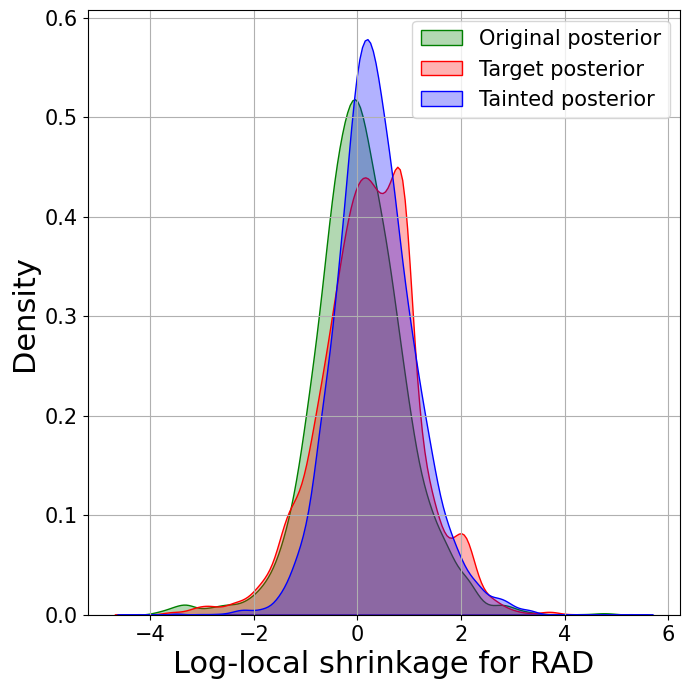

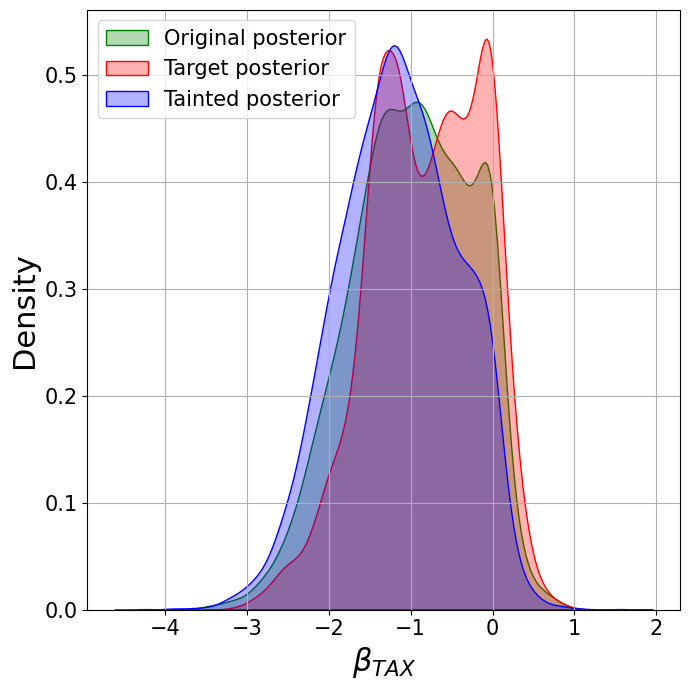

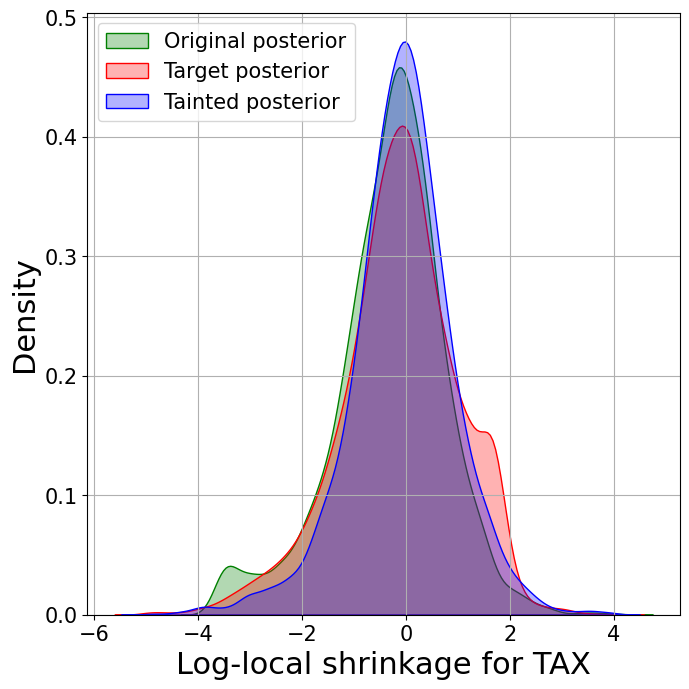

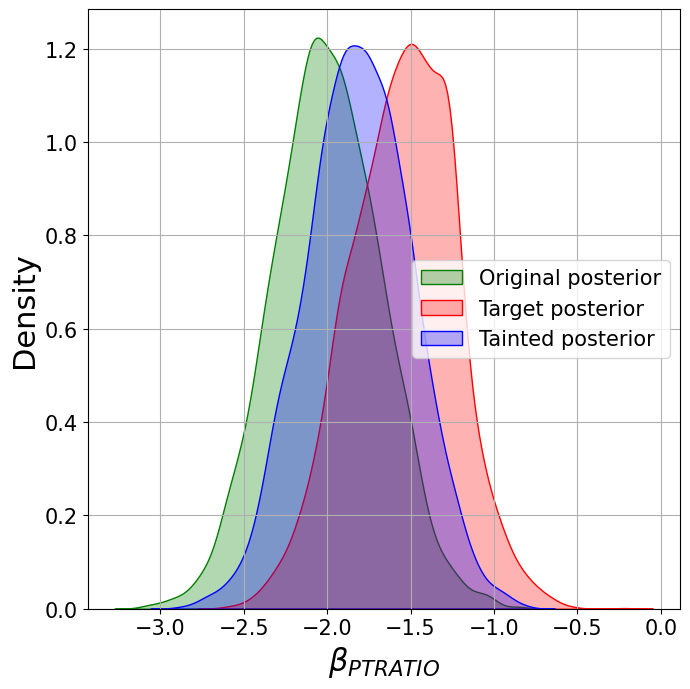

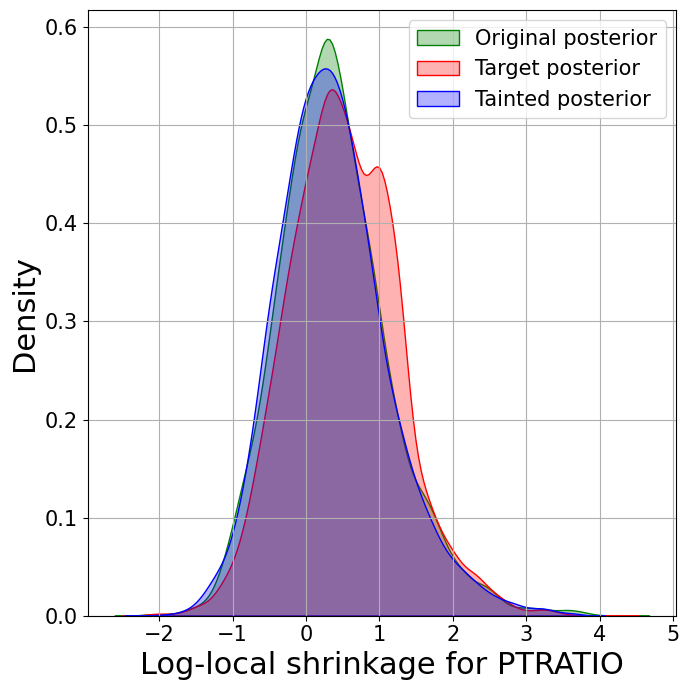

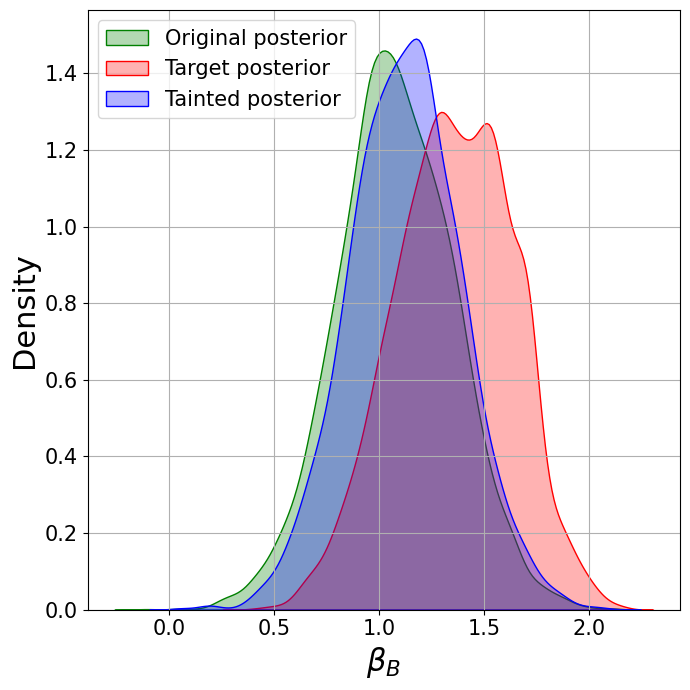

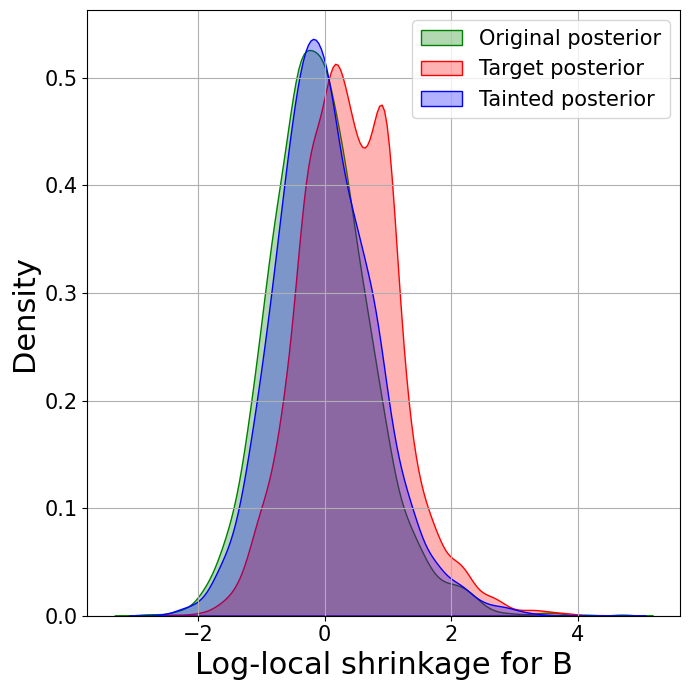

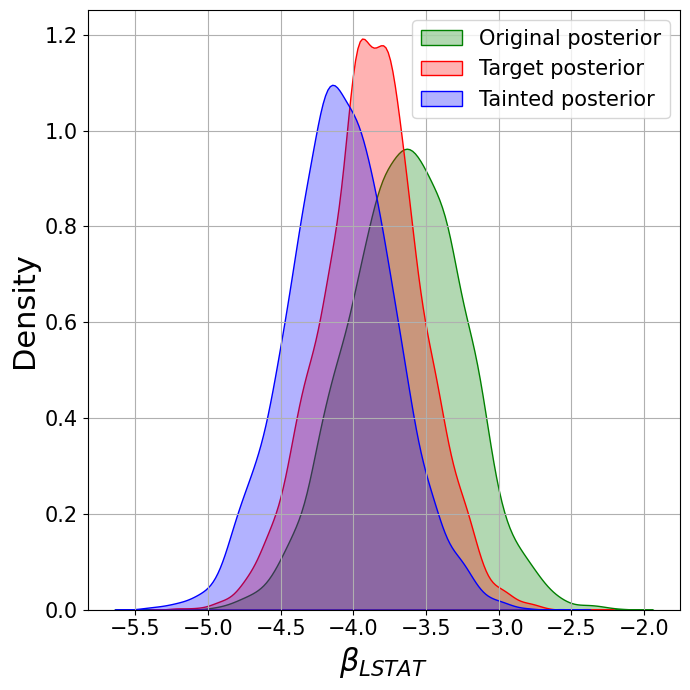

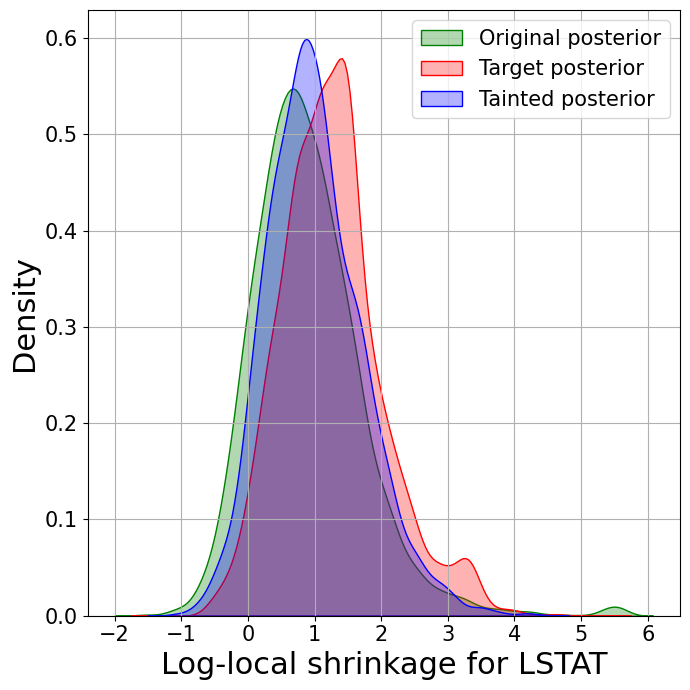

In [74]:
for i, name in enumerate(feature_names):
    plot_samples_kde_single_param(samples_HS["beta"][:, i], 
                                  samples_target_HS["beta"][:, i], 
                                  attacked_posterior_samples["beta"][:, i], 
                                  xlabel="$\\beta_{" + name + "}$", 
                                  xlim=None)
    
    plot_samples_kde_single_param(np.log(samples_HS["local_shrinkage"][:, i]), 
                                  np.log(samples_target_HS["local_shrinkage"][:, i]), 
                                  np.log(attacked_posterior_samples["local_shrinkage"][:, i]), 
                                  xlabel="Log-local shrinkage for " + name, 
                                  xlim=None)

# Attacks against NIG model

In [17]:
results = {}
max_occurence = 2 
max_L1_list = [10, 20, 30, 40, 50, 60]
n_repeats = 5

model = model_NIG
sample_adv = sample_adv_NIG

params_FGSM = {"heuristic": "FGSM",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 1000,
               "max_iterations": None,
               "stopping_ratio": None,
               "betas": None,
               "eps": None,
               "lr": None
                }

params_2O_ISCD = {"heuristic": "2O-ISCD",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 100,
               "max_iterations": max(max_L1_list) + 5,
               "stopping_ratio": None,
               "betas": None,
               "eps": None,
               "lr": None
                }

params_2O_R2 = {"heuristic": "2O-R2",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 100,
               "max_iterations": 10,
               "stopping_ratio": 1e-3,
               "betas": None,
               "eps": 1e0,
               "lr": None
                }


params_dicts_list = [params_FGSM, params_2O_ISCD, params_2O_R2]


In [140]:
torch.manual_seed(0)

for params_dict in params_dicts_list:

    print(params_dict["heuristic"])
    
    results_heuristic = {}
    
    for max_L1 in tqdm(max_L1_list):
            
        results_L1 = {  "weights": [], 
                        "L1": [], 
                        "a": [], 
                        "b": [],
                        "mean": [], 
                        "cov": [],
                        "KLs": []}
        
        for i in range(n_repeats):
            

            opti = WeightsOptimizer(data_NIG, model, sample_adv)

            weights = opti.optimize(max_occurence=max_occurence, max_L1=max_L1,
                                            heuristic=params_dict["heuristic"],
                                            n_MC_samples_adv=params_dict["n_MC_samples_adv"],
                                            n_MC_samples_post=params_dict["n_MC_samples_post"],
                                            max_iterations=params_dict["max_iterations"],
                                            stopping_ratio=params_dict["stopping_ratio"],
                                            eps=params_dict["eps"],
                                            lr=params_dict["lr"],
                                            verbose=False, 
                                            make_plots=False)
            
            mu_ast, v_ast, a_ast, b_ast = model.posterior_parameters(data_NIG, weights=weights) 
            tau_post = Gamma(a_ast, b_ast)
            beta_post = MultivariateNormal(mu_ast, v_ast / tauA)

            kl_est = float(nig_kl_div(tau_adv_dist, beta_adv_dist, tau_post, beta_post).detach().numpy())

            results_L1["weights"].append(weights)
            L1 = float(torch.norm(torch.ones(n_points) - weights, p=1))
            results_L1["L1"].append(L1)
            results_L1["a"].append(a_ast)
            results_L1["b"].append(b_ast)
            results_L1["mean"].append(mu_ast)
            results_L1["cov"].append(v_ast)
            results_L1["KLs"].append(kl_est)
        
        # Store as tensors
        for key in results_L1.keys():
            results_L1[key] = to_tensor(results_L1[key])
        
        # Save the dictionary of results for this max_L1 value
        results_heuristic[max_L1] = results_L1

    # Save the dictionary of results for this heuristic
    results[params_dict["heuristic"]] = results_heuristic

FGSM


100%|██████████| 6/6 [00:00<00:00, 31.24it/s]


2O-ISCD


100%|██████████| 6/6 [00:04<00:00,  1.20it/s]


2O-R2


100%|██████████| 6/6 [00:40<00:00,  6.70s/it]


In [141]:
save_path = None#"../../output/boston/results_RM_NIG"
if save_path is not None:
    torch.save(results, save_path)

In [18]:
load_path = "../../output/boston/results_RM_NIG"
if load_path is not None:
    results = torch.load(load_path)

/tmp/ipykernel_1483427/2739448618.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(load_path)


In [19]:
AX_LBL_SIZE = 22
TICKS_LBL_SIZE = 15
LEGEND_LBL_SIZE = 15

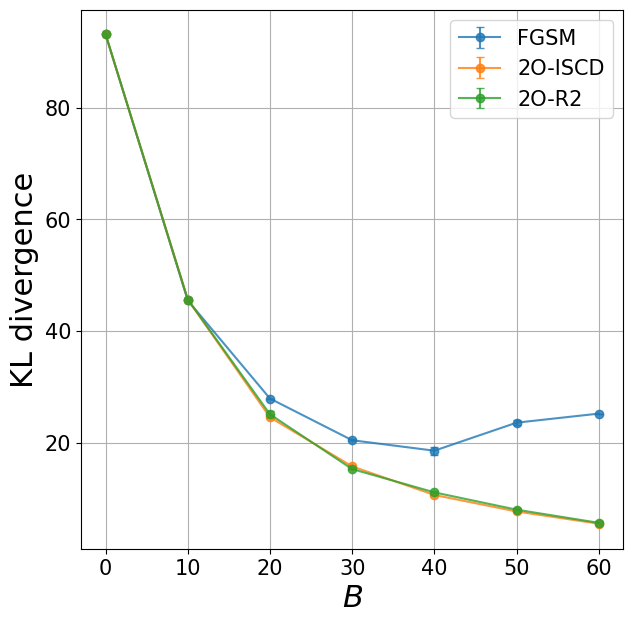

In [20]:
error_bar_scale = 1.96
not_show = []

plt.figure(figsize=(7, 7))

mu_ast, v_ast, a_ast, b_ast = model.posterior_parameters(data_NIG) 
tau_post = Gamma(a_ast, b_ast)
beta_post = MultivariateNormal(mu_ast, v_ast / tauA)

KL_orig_NIG = float(nig_kl_div(tau_adv_dist, beta_adv_dist, tau_post, beta_post).detach().numpy())


for heuristic in results.keys():
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    KL_means = torch.zeros(len(results_heuristic) + 1)
    KL_stds = torch.zeros(len(results_heuristic) + 1)
    KL_means[0] = KL_orig_NIG
    for i, max_L1 in enumerate(results_heuristic.keys()):
        KL_repeats = results_heuristic[max_L1]["KLs"]
        KL_means[i + 1] = KL_repeats.mean()
        KL_stds[i + 1] = KL_repeats.std() / np.sqrt(len(KL_repeats))
    plt.errorbar([0] + list(results_heuristic.keys()), KL_means, yerr=KL_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
#plt.yscale('log')
plt.ylabel("KL divergence", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

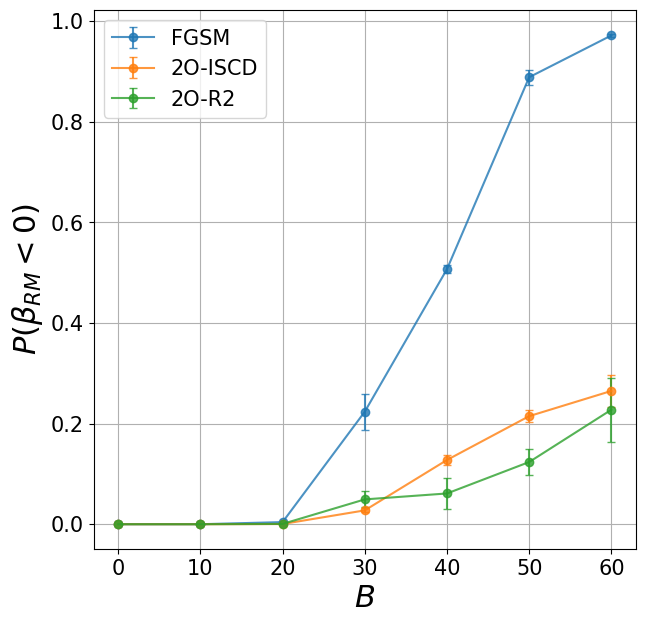

In [21]:
threshold = 0.0
n_samples_post = 10000

not_show = []
plt.figure(figsize=(7, 7))

torch.manual_seed(0)
samples_orig = model_NIG.sample_posterior(n_samples_post, data_NIG)
prob_neg_orig = torch.sum(samples_orig["beta"][:, target_id + 1] < threshold) / n_samples_post

for heuristic in results.keys():
    if heuristic in not_show:
        continue
    results_heuristic = results[heuristic]
    prob_neg_means = torch.zeros(len(results_heuristic) + 1)
    prob_neg_stds = torch.zeros(len(results_heuristic) + 1)
    prob_neg_means[0] = prob_neg_orig

    for i, max_L1 in enumerate(results_heuristic.keys()):
        n = len(results_heuristic[max_L1]["weights"])
        prob_neg_repeats = torch.zeros(n)

        for j in range(n):
            samples = model.sample_posterior(n_samples_post, data_NIG, weights=results_heuristic[max_L1]["weights"][j])
            prob_neg_repeats[j] = torch.sum(samples["beta"][:, target_id + 1] < threshold) / n_samples_post

        prob_neg_means[i + 1] = prob_neg_repeats.mean()

        prob_neg_stds[i + 1] = prob_neg_repeats.std() / np.sqrt(n)

    plt.errorbar([0] + list(results_heuristic.keys()), prob_neg_means, yerr=prob_neg_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)


plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("$P(\\beta_{RM} < 0)$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()

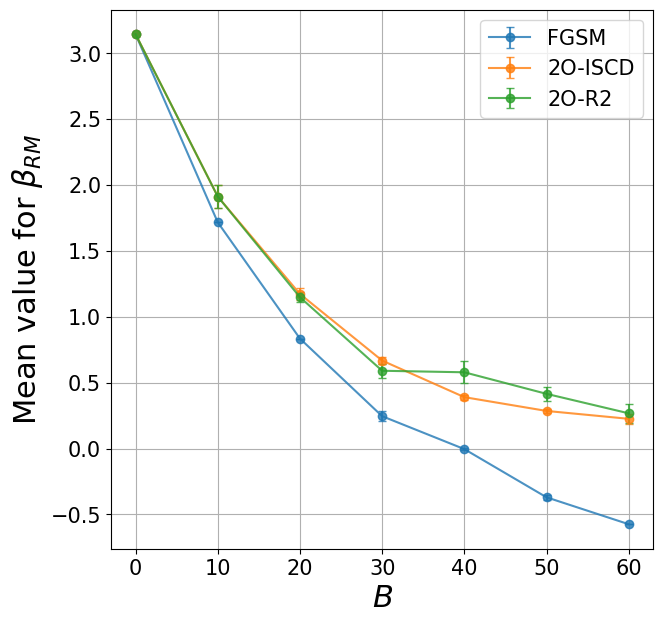

In [22]:
error_bar_scale = 1.96
not_show = []
plt.figure(figsize=(7, 7))

mu_ast, v_ast, a_ast, b_ast = model_NIG.posterior_parameters(data_NIG) 

for heuristic in results.keys():
    
    if heuristic in not_show:
        continue

    results_heuristic = results[heuristic]
    mean_means = torch.zeros(len(results_heuristic) + 1)
    mean_stds = torch.zeros(len(results_heuristic) + 1)
    mean_means[0] = mu_ast[target_id + 1]
    for i, max_L1 in enumerate(results_heuristic.keys()):
        mean_repeats = results_heuristic[max_L1]["mean"][:, target_id + 1]
        mean_means[i + 1] = mean_repeats.mean()
        mean_stds[i + 1] = mean_repeats.std() / np.sqrt(len(mean_repeats))

    plt.errorbar([0] + list(results_heuristic.keys()), mean_means, yerr=mean_stds*error_bar_scale, alpha=0.8, label=heuristic, fmt="o-", capsize=3)

plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.xlabel("$B$", fontsize=AX_LBL_SIZE)
plt.legend(fontsize=LEGEND_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.ylabel("Mean value for $\\beta_{RM}$", fontsize=AX_LBL_SIZE)
plt.grid(True)
plt.show()


In [23]:
torch.manual_seed(0)
samples_NIG = model_NIG.sample_posterior(5000, data_NIG, warmup_steps=100)
samples_target_NIG = sample_adv_NIG(5000)

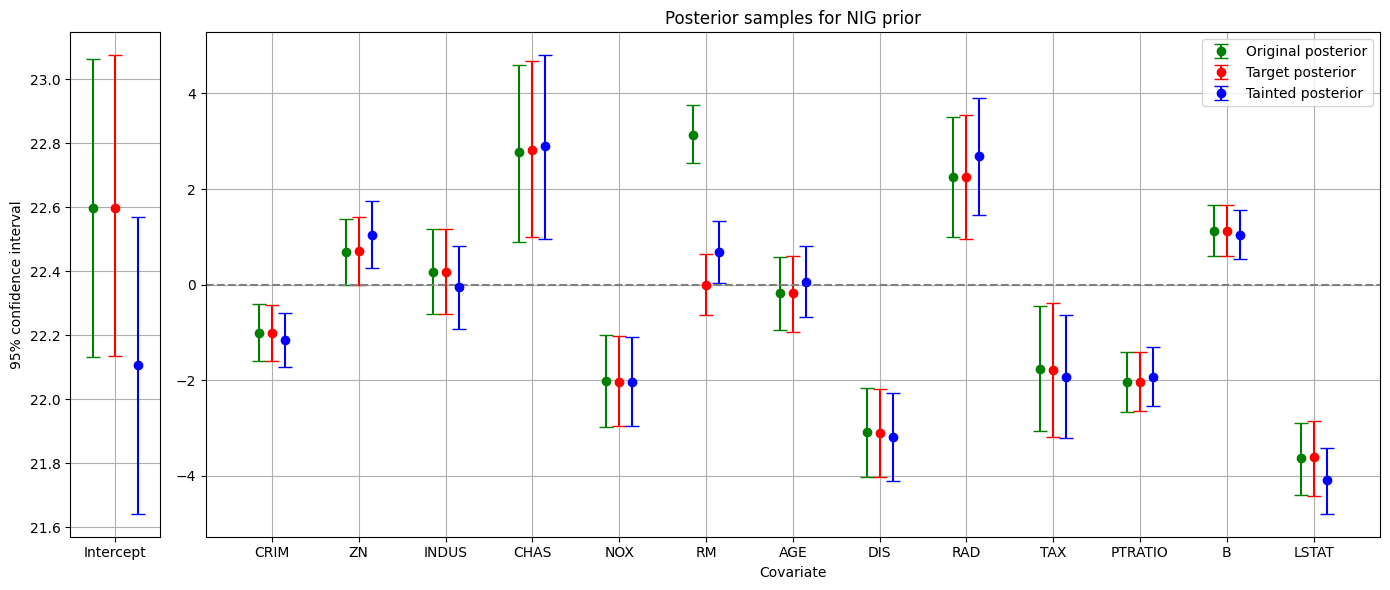

In [24]:
max_L1 = 30
heuristic = "2O-ISCD"

weights_NIG = results[heuristic][max_L1]["weights"][-1]

torch.manual_seed(0)
samples_tainted_NIG = model_NIG.sample_posterior(5000, data_NIG, weights_NIG, warmup_steps=100)


plot_intervals_NIG(samples_NIG["beta"].data.numpy(), 
               samples_target_NIG["beta"].data.numpy(), 
               samples_tainted_NIG["beta"].data.numpy(), 
               title='Posterior samples for NIG prior')

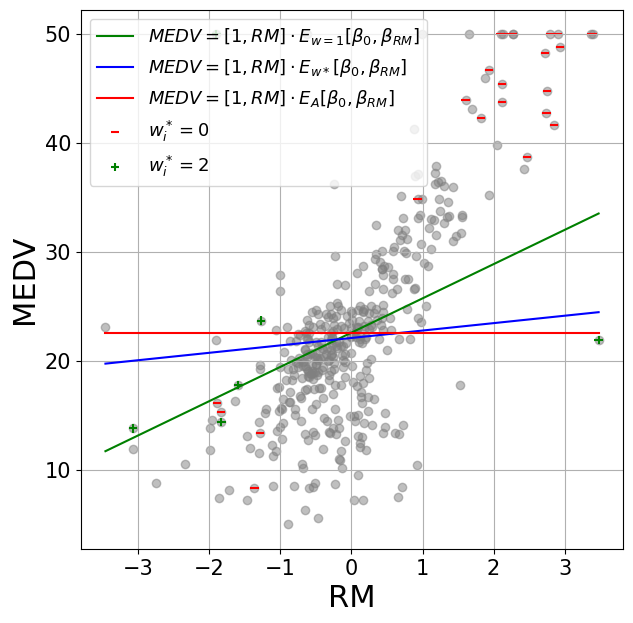

In [25]:
n_samples_plot = 5000

def plot_regression_line(intercept, slope, color, label, linestyle=None):
    x1 = X_train[:, target_id + 1].min()
    x2 = X_train[:, target_id + 1].max()

    y1 = intercept + x1 * slope
    y2 = intercept + x2 * slope
    plt.plot([x1, x2], [y1, y2], 
            color=color, label=label, linestyle=linestyle)

mu_ast, v_ast, a_ast, b_ast = model_NIG.posterior_parameters(data_NIG) 

original_mean_beta = to_np(mu_ast[1:])
original_intercept = to_np(mu_ast[0])


mu_ast, v_ast, a_ast, b_ast = model_NIG.posterior_parameters(data_NIG, weights_NIG) 
attacked_mean_beta = to_np(mu_ast[1:])
attacked_intercept = to_np(mu_ast[0])

intercept_adv = to_np(muA[0])
slope_adv = to_np(muA[1:])


plt.figure(figsize=(7, 7))

plot_regression_line(original_intercept, original_mean_beta[target_id], 
                        CLR_ORIGINAL, "$MEDV = [1, RM] \\cdot E_{w=1}[\\beta_0, \\beta_{RM}]$")
plot_regression_line(attacked_intercept, attacked_mean_beta[target_id], 
                        CLR_TAINTED, "$MEDV = [1, RM] \\cdot E_{w*}[\\beta_0, \\beta_{RM}]$")
plot_regression_line(intercept_adv, slope_adv[target_id], CLR_TARGET, "$MEDV = [1, RM] \\cdot E_A[\\beta_0, \\beta_{RM}]$")

# Plot the datapoints
plt.scatter(X_train[:, target_id + 1], y_train, color="gray", alpha=0.5) 

# Plot the + and - symbols
plt.scatter(X_train[:, target_id + 1], y_train, color="red", marker='_', alpha=(weights_NIG < 1).data)
plt.scatter(X_train[:, target_id + 1], y_train, color="green", marker='+', alpha=(weights_NIG > 1).data)
plt.scatter([], [], color="red", marker='_',  label="$w^*_i=0$") # "Removed points"
plt.scatter([], [], color="green", marker='+', label="$w^*_i=2$") # "Duplicated points"
plt.grid(True)
plt.ylabel("MEDV", fontsize=AX_LBL_SIZE)
plt.xlabel(target_feature, fontsize=AX_LBL_SIZE)
plt.legend(fontsize=13, loc="upper left")
plt.xticks(fontsize=TICKS_LBL_SIZE)
plt.yticks(fontsize=TICKS_LBL_SIZE)
plt.show()

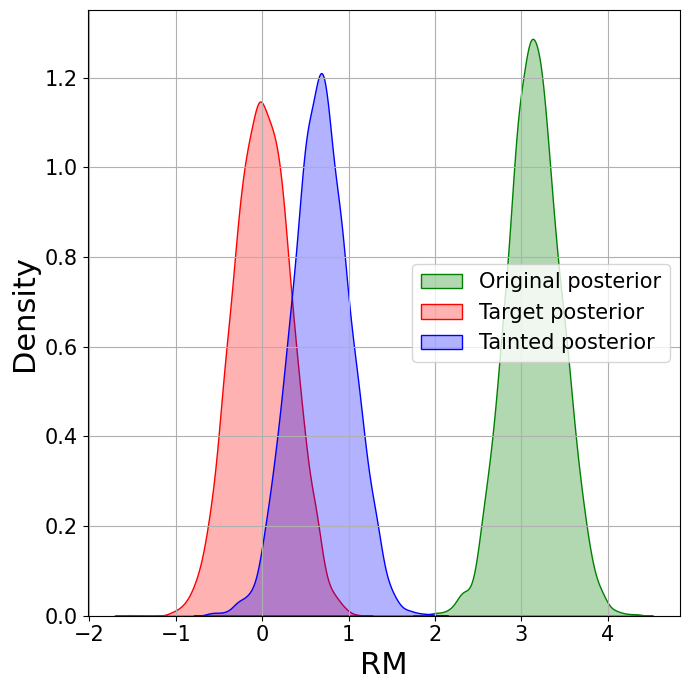

In [26]:
plot_samples_kde_single_param(samples_NIG["beta"][:, target_id + 1].data.numpy(), 
               samples_target_NIG["beta"][:, target_id + 1].data.numpy(), 
               samples_tainted_NIG["beta"][:, target_id + 1].data.numpy(), 
                                xlabel="RM", 
                                xlim=None)